# EFFECT OF IVF TREATMENT REGIMENS ON PROBABILITY OF SUCCESSFUL PREGNANCY 

## Data Preparation

In [3]:
# import all relevant packages and set settings for work environment #
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from scipy.stats import ttest_ind
from scipy import stats
import math 
import seaborn as sns
import matplotlib.pyplot as plt
#!pip install psmpy
#!pip install lightgbm
import psmpy
import lightgbm as ltb
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression as lr
from lightgbm.plotting import plot_importance
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import sys

import statistics
from math import sqrt


if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")




sns.set(rc={'figure.figsize':(16,10)}, font_scale=1.3)
pd.set_option('display.max_columns', 70)
pd.set_option('display.max_rows', 300)


In [4]:
# Loading the dataset

data=pd.read_csv('Workdata.csv')

data.head()

,Patiant ID,IVF Number,Weight,Height,BMI,Age,Birth Date,Total Pregnancies,Total Births,Protocol,Path,ICSI,Pregnant,Start Of IVF Cycle,Med1,Med2,Med3,Ovulation Inducing Medication
0,0029b5cc1f1470b3d3ad75bf4e87ec1848f97d5b08f124...,1,65.0,150.0,28.888889,27.351129,8/3/1990,0,0,Antagonist,Fresh,1,0,12/9/2017,Gonal,Cetrotide,Ovitrelle,Deca 0.2 mg + Ovit 250Mcg
1,0029b5cc1f1470b3d3ad75bf4e87ec1848f97d5b08f124...,4,65.0,150.0,28.888889,28.235455,8/3/1990,0,0,Antagonist,Fresh,1,0,10/28/2018,Gonal,Cetrotide,Utrogestan,Deca 0.2 mg + Ovit 250Mcg
2,0029b5cc1f1470b3d3ad75bf4e87ec1848f97d5b08f124...,5,65.0,150.0,28.888889,28.361396,8/3/1990,0,0,Antagonist,Fresh,1,0,12/13/2018,Gonal,Cetrotide,Decapeptyl,Deca 0.2 mg + Ovit 250Mcg
3,0029b5cc1f1470b3d3ad75bf4e87ec1848f97d5b08f124...,6,65.0,150.0,28.888889,28.561259,8/3/1990,0,0,Antagonist,Fresh,1,0,2/24/2019,Gonal,Cetrotide,Decapeptyl,Deca 0.2 mg + Ovit 250Mcg
4,0029b5cc1f1470b3d3ad75bf4e87ec1848f97d5b08f124...,7,65.0,150.0,28.888889,28.777550,8/3/1990,0,0,Antagonist,Fresh,1,0,5/14/2019,Menopur,Cetrotide,Decapeptyl,Decapeptyl 0.2 Mg


In [5]:
data_med=data[['Med1','Med2','Med3']]
x=[data_med.iloc[1]['Med1'],data_med.iloc[1]['Med2'],data_med.iloc[1]['Med3']]
b=list(set(x))
# print(" The medication for the first women treatment record's of :",sorted(b))
print("Example of how a treatment regimen is described:",sorted(b))

Example of how a treatment regimen is described: ['Cetrotide', 'Gonal', 'Utrogestan']


In [6]:
#Extract all the posible treatment regimens in dataset
data_med=data[['Med1','Med2','Med3']]
combination={}
for i in range(data_med.shape[0]):
    x=[data_med.iloc[i]['Med1'],data_med.iloc[i]['Med2'],data_med.iloc[i]['Med3']]
    x=sorted(list(set(x)))
    if str(x) in combination.keys():
        combination[str(x)]+=1
    else:
        combination[str(x)]=1
    
combination=pd.DataFrame.from_dict(combination ,orient='index')

print("Total posible treatment regimens :", len(combination))

print("The 3 most common treatments in the dataset :", combination[0].nlargest(3))


Total posible treatment regimens : 109
The 3 most common treatments in the dataset : ['Cetrotide', 'Decapeptyl', 'Menopur']       815
['Cetrotide', 'Decapeptyl', 'Gonal']         587
['Decapeptyl', 'Ovitrelle', 'Pergoveris']    563
Name: 0, dtype: int64


### Keeping only cases treated with one of the 3-most common treatments 

In [7]:
d=combination.sort_values(0)
# Trimming data for lower runtime #
b=d.loc[d[0] >= 500]

list_of=[0 for i in range(data_med.shape[0])]
# Define ['Decapeptyl', 'Ovitrelle', 'Pergoveris'] as T = 0 , ['Cetrotide', 'Decapeptyl', 'Gonal'] as T = 1 and ['Cetrotide', 'Decapeptyl', 'Menopur'] as T = 2
x=[['Decapeptyl', 'Ovitrelle', 'Pergoveris'],['Cetrotide', 'Decapeptyl', 'Gonal'],['Cetrotide', 'Decapeptyl', 'Menopur']]
for i in range(data_med.shape[0]):
    y=[data_med.iloc[i]['Med1'],data_med.iloc[i]['Med2'],data_med.iloc[i]['Med3']]
    y=sorted(list(set(y)))
    if y in x:
        list_of[i]=1
x=data.copy()

x['index']=list_of
top_3_data=x[x['index']==1]
print('Pregnancy frequency before trimming:\n', 100 * data['Pregnant'].value_counts()/data.shape[0])
print('Pregnancy frequency after trimming:\n', 100 * top_3_data['Pregnant'].value_counts()/top_3_data.shape[0])

# frequency of pregnancy remains similar #

Pregnancy frequency before trimming:
 0    87.566686
1    12.433314
Name: Pregnant, dtype: float64
Pregnancy frequency after trimming:
 0    87.83715
1    12.16285
Name: Pregnant, dtype: float64


### Coding drug combinations as treatment variable  

In [8]:
for idx, row in top_3_data.iterrows():
    x=[['Decapeptyl', 'Ovitrelle', 'Pergoveris'],['Cetrotide', 'Decapeptyl', 'Gonal'],['Cetrotide', 'Decapeptyl', 'Menopur']]
    y=[row['Med1'],row['Med2'],row['Med3']]
    y=sorted(list(set(y)))
    if y==x[0]:
        top_3_data.at[idx,'T']=0
    elif y==x[1]:
        top_3_data.at[idx,'T']=1
    else:
        top_3_data.at[idx,'T']=2

new=top_3_data[['BMI','IVF Number','Age','Total Pregnancies','Total Births','T','Pregnant']].copy()

print("Number of record before delition of records with null values:",new.shape[0])
new_data=new.dropna() # delete rows that contain missing values 
new_data.drop(new_data[new_data['BMI'] >= 50 ].index, inplace=True) # Remove rows with improbable values BMI
data_backup=new_data.copy() #backing up file, just in case 
print("Number of record after delition of records with null values:",new_data.shape[0])
new_data.reset_index()


Number of record before delition of records with null values: 1965
Number of record after delition of records with null values: 1938


,index,BMI,IVF Number,Age,Total Pregnancies,Total Births,T,Pregnant
0,2,28.888889,5,28.361396,0,0,1.0,0
1,3,28.888889,6,28.561259,0,0,1.0,0
2,4,28.888889,7,28.777550,0,0,2.0,0
3,5,28.888889,9,29.259411,0,0,1.0,0
4,6,28.888889,11,29.574264,0,0,1.0,0
...,...,...,...,...,...,...,...,...
1933,6719,23.634033,2,27.416838,0,0,2.0,0
1934,6720,28.650138,2,39.121150,0,0,0.0,0
1935,6731,21.875000,1,38.784394,2,2,2.0,0
1936,6732,21.875000,2,39.173169,2,2,2.0,0


### Categorizing BMI into categories 

<AxesSubplot:>

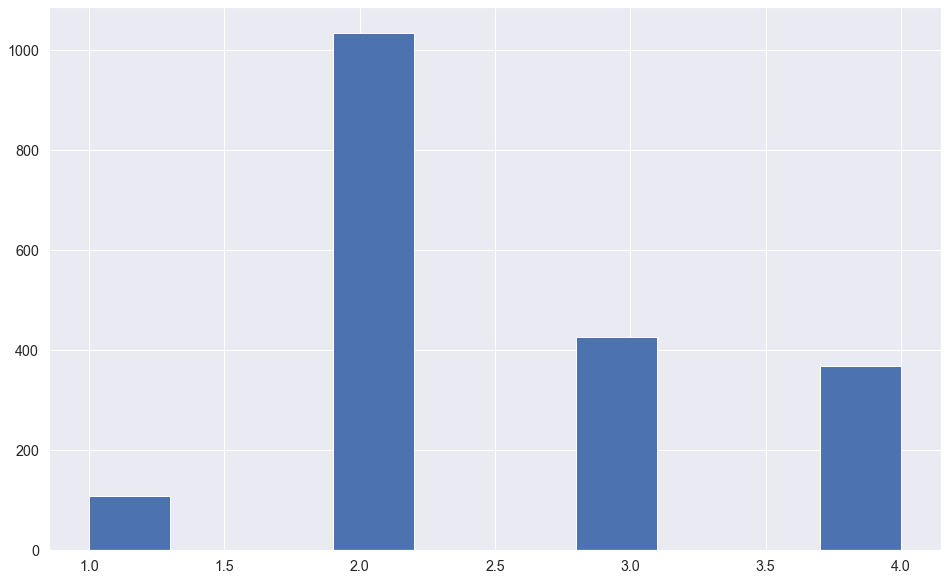

In [9]:
for idx, row in new_data.iterrows():
     
    if row['BMI'] <= 18.5:
        new_data.at[idx,'BMI_cat']=1 #'underweight'
      
    elif 18.5 < row['BMI'] <= 24.9:
        new_data.at[idx,'BMI_cat']=2 #'normal'
       
    elif 25 <row['BMI'] <= 29.29:
        new_data.at[idx,'BMI_cat']=3 #'overweight'
        
    else:
        new_data.loc[idx,'BMI_cat']=4 #'obese'

# Checking distribution of BMI category variable 
new_data['BMI_cat'].hist()

### Categorizing Age into categories 

<AxesSubplot:>

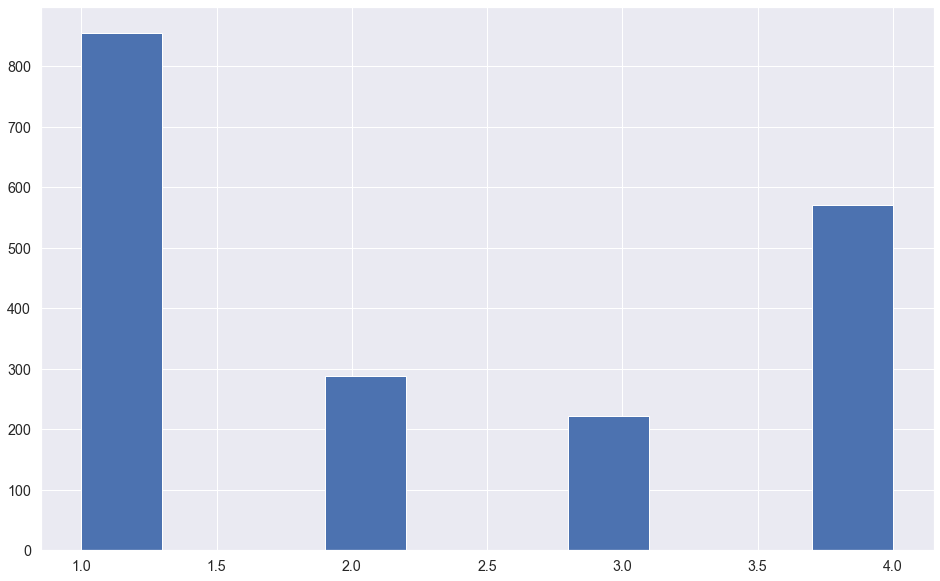

In [10]:
for idx, row in new_data.iterrows():
    if row['Age'] <= 35:
         new_data.at[idx,'Age_cat']=1 #'very young'
    elif 35 < row['Age'] <= 37:
        new_data.at[idx,'Age_cat']=2 #'young'
    elif 38 < row['Age'] <= 40:
        new_data.at[idx,'Age_cat']=3 #'old'
    else:
        new_data.at[idx,'Age_cat']=4 #'veryold'
        
# Checking distribution of Age category variable 
new_data['Age_cat'].hist()

### Creation of Failed Pregnancies variable from Total Pregnancies - Total Births 

In [11]:
for idx, row in new_data.iterrows():
    new_data.at[idx,'faildpregnancies']=row['Total Pregnancies']-row['Total Births']
new_data = new_data.drop(new_data[new_data['faildpregnancies'] < 0 ].index)
new_data=new_data.drop(['Total Pregnancies', 'Total Births'], axis=1)

### Splitting the data into treated and control groups based on the values of T (Treatment)

T=0:Decapeptyl, Ovitrelle, Pergoveris

T=1:Cetrotide, Decapeptyl, Gonal

T=2:Cetrotide, Decapeptyl, Menopur

### Treatment group : T=1 Control Group : T=0

In [12]:
# Split the data into treatment and control groups for each Treatment
T1_treated = new_data[new_data['T'] == 1].copy()
T1_control_0 = new_data[new_data['T']  == 0].copy()


merge1_0=T1_treated.append(T1_control_0)
merge1_0=merge1_0.reset_index()

merge1_0.drop('index', inplace=True, axis=1)
merge1_0.drop('BMI', inplace=True, axis=1)
merge1_0.drop('Age', inplace=True, axis=1)

### Checking for difference in features between treatment and control group

In [13]:
merge1_0.groupby('T').mean()

,IVF Number,Pregnant,BMI_cat,Age_cat,faildpregnancies
T,,,,,
0.0,3.769094,0.174067,2.634103,2.889876,0.849023
1.0,1.739510,0.118881,2.440559,1.414336,0.307692


### Distribution of Age variable between treatment and control groups

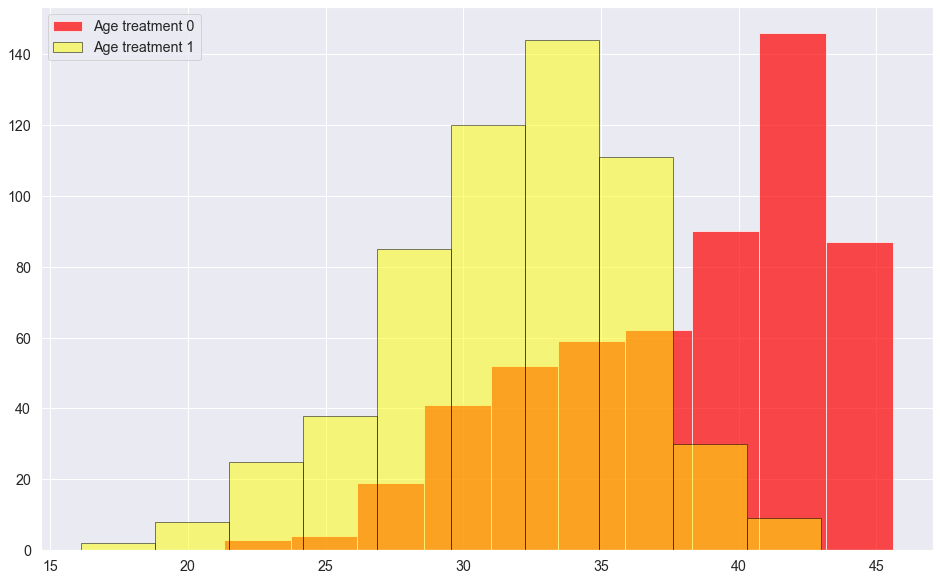

In [14]:

# plotting  age histogram for treatment 0
plt.hist(T1_control_0['Age'], label='Age treatment 0', alpha=.7, color='red')

# plotting control 1 age histogram
plt.hist(T1_treated['Age'], label="Age treatment 1", alpha=.5,
         edgecolor='black', color='yellow')

plt.legend()
 
# Showing the plot using plt.show()
plt.show()


### Checking for difference in age between T = 0 and T = 1 via mean comparison

In [15]:
# t-test for Age (dependent variable)
print(T1_control_0['Age'].mean(), T1_treated['Age'].mean())

# compare samples
_, p = ttest_ind(T1_control_0['Age'], T1_treated['Age'])
print(f'p={p:.3f}')

# interpret
alpha = 0.05  # significance level
print("The age field of treatment 1 and 0 have:")
if p > alpha:
    print('similar means (we do not have enough evidence to reject the Null Hypothesis)')
else:
    print('different group means and hence we reject the Null Hypothesis')

38.101103529023035 31.863791923304195
p=0.000
The age field of treatment 1 and 0 have:
different group means and hence we reject the Null Hypothesis


### Distribution of BMI variable between treatment and control groups

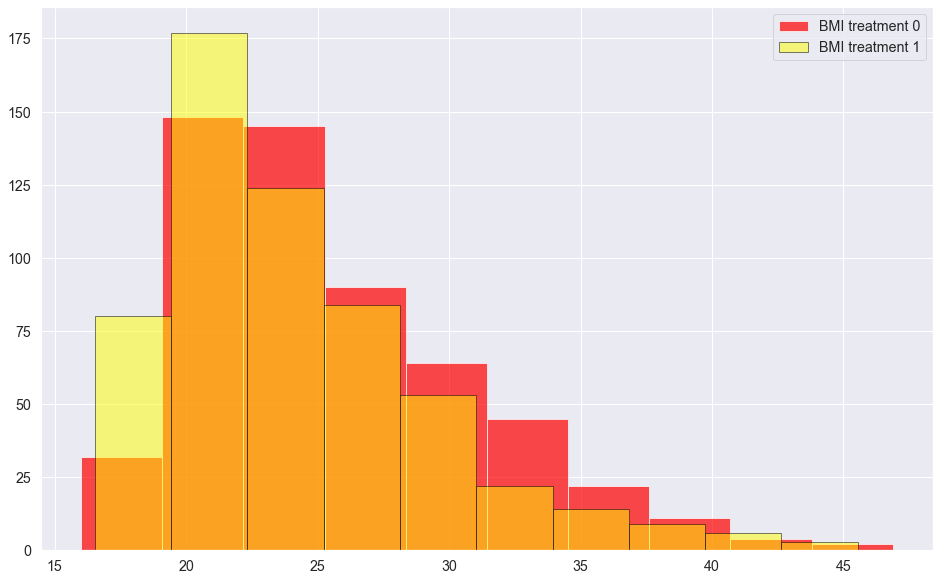

25.5216678065187 24.223031912797204
p=0.000
The BMI field of treatment 1 and 0 have:
different group means and hence we reject the Null Hypothesis


In [16]:

# plotting treatment 0 BMI histogram
plt.hist(T1_control_0['BMI'], label='BMI treatment 0', alpha=.7, color='red')


# plotting treatment 1 BMI histogram
plt.hist(T1_treated['BMI'], label="BMI treatment 1", alpha=.5,
         edgecolor='black', color='yellow')

plt.legend()
 
# Showing the plot using plt.show()
plt.show()

# t-test for BMI (dependent variable)
from scipy.stats import ttest_ind

print(T1_control_0['BMI'].mean(), T1_treated['BMI'].mean())

# compare samples
_, p = ttest_ind(T1_control_0['BMI'], T1_treated['BMI'])
print(f'p={p:.3f}')

# interpret
alpha = 0.05  # significance level
print("The BMI field of treatment 1 and 0 have:")
if p > alpha:
    print('similar means (we do not have enough evidence to reject the Null Hypothesis)')
else:
    print('different group means and hence we reject the Null Hypothesis')

### Distribution of Failed Pregnancies variable between treatment and control groups

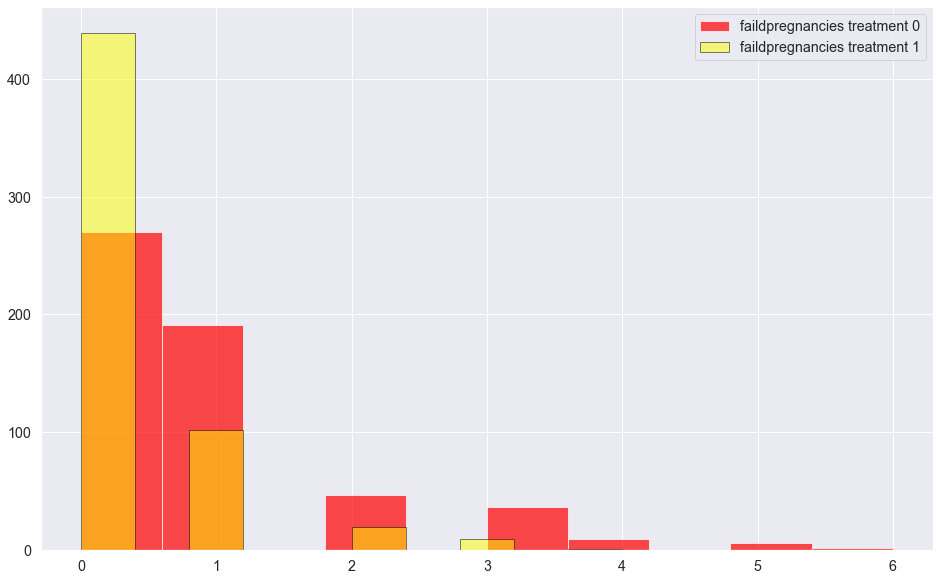

0.8490230905861457 0.3076923076923077
p=0.000
The faild pregnancies field of treatment 1 and 0 have:
different distributions/different group mean (reject H0)


In [17]:

# plotting treatment 0 faild Pregnancies histogram
plt.hist(T1_control_0['faildpregnancies'], label='faildpregnancies treatment 0', alpha=.7, color='red')

 
# plotting treatment 1 faild Pregnancies histogram
plt.hist(T1_treated['faildpregnancies'], label="faildpregnancies treatment 1", alpha=.5,
         edgecolor='black', color='yellow')

plt.legend()
 
# Showing the plot using plt.show()
plt.show()


#  t-test for faild Pregnancies (dependent variable)
from scipy.stats import ttest_ind

print(T1_control_0['faildpregnancies'].mean(), T1_treated['faildpregnancies'].mean())

# compare samples
_, p = ttest_ind(T1_control_0['faildpregnancies'], T1_treated['faildpregnancies'])
print(f'p={p:.3f}')

# interpret
alpha = 0.05  # significance level
print("The faild pregnancies field of treatment 1 and 0 have:")
if p > alpha:
    print(' same distributions/same group mean (fail to reject H0 - we do not have enough evidence to reject H0)')
else:
    print('different distributions/different group mean (reject H0)')

### Distribution of IVF Number variable between treatment and control groups

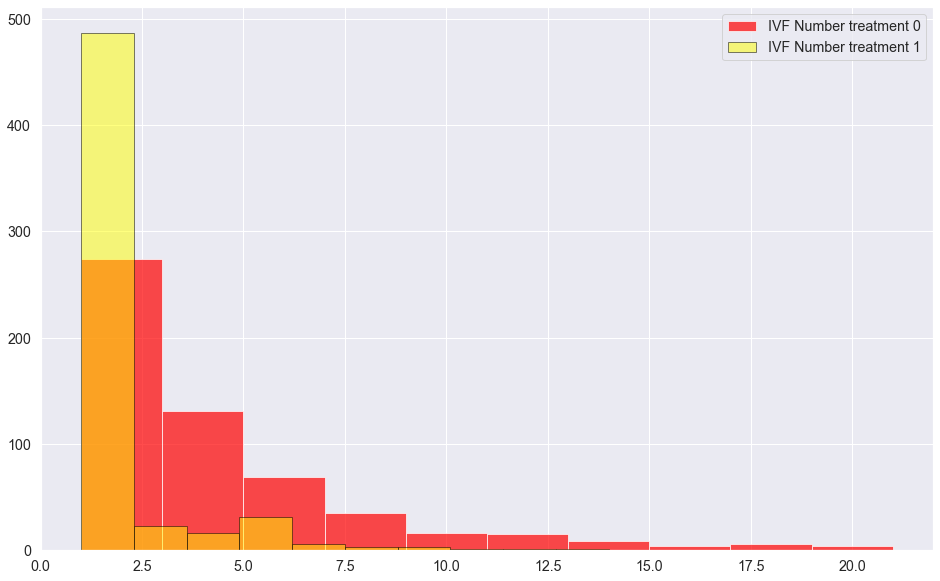

3.769094138543517 1.7395104895104896
p=0.000
The IVF Number field of treatment 1 and 0 have:
different distributions/different group mean (reject H0)


In [18]:

# plotting treatment 0 IVF Number histogram
plt.hist(T1_control_0['IVF Number'], label='IVF Number treatment 0', alpha=.7, color='red')

# plotting treatment 1 IVF Number histogram
plt.hist(T1_treated['IVF Number'], label="IVF Number treatment 1", alpha=.5,
         edgecolor='black', color='yellow')

plt.legend()
 
# Showing the plot using plt.show()
plt.show()

#  t-test for IVF Numeber (dependent variable)
from scipy.stats import ttest_ind

print(T1_control_0['IVF Number'].mean(), T1_treated['IVF Number'].mean())

# compare samples
_, p = ttest_ind(T1_control_0['IVF Number'], T1_treated['IVF Number'])
print(f'p={p:.3f}')

# interpret
alpha = 0.05  # significance level
print("The IVF Number field of treatment 1 and 0 have:")
if p > alpha:
    print(' same distributions/same group mean (fail to reject H0 - we do not have enough evidence to reject H0)')
else:
    print('different distributions/different group mean (reject H0)')

### Checking for correlations between features and removing variables that are correlated as needed

In [19]:
new_data_no_bmi_age=new_data.copy()
new_data_no_bmi_age.drop('Age', inplace=True, axis=1)
new_data_no_bmi_age.drop('BMI', inplace=True, axis=1)
cor_matrix=new_data_no_bmi_age.corr().abs()
display(cor_matrix)

,IVF Number,T,Pregnant,BMI_cat,Age_cat,faildpregnancies
IVF Number,1.000000,0.184694,0.059183,0.062228,0.222370,0.302883
T,0.184694,1.000000,0.110606,0.030713,0.106833,0.114474
Pregnant,0.059183,0.110606,1.000000,0.005157,0.031351,0.251346
BMI_cat,0.062228,0.030713,0.005157,1.000000,0.082105,0.089305
Age_cat,0.222370,0.106833,0.031351,0.082105,1.000000,0.162119
faildpregnancies,0.302883,0.114474,0.251346,0.089305,0.162119,1.000000


In [20]:
upper_tri = cor_matrix.where(np.triu(np.ones(cor_matrix.shape),k=1).astype(np.bool))
display(upper_tri)

,IVF Number,T,Pregnant,BMI_cat,Age_cat,faildpregnancies
IVF Number,NaN,0.184694,0.059183,0.062228,0.222370,0.302883
T,NaN,NaN,0.110606,0.030713,0.106833,0.114474
Pregnant,NaN,NaN,NaN,0.005157,0.031351,0.251346
BMI_cat,NaN,NaN,NaN,NaN,0.082105,0.089305
Age_cat,NaN,NaN,NaN,NaN,NaN,0.162119
faildpregnancies,NaN,NaN,NaN,NaN,NaN,NaN


# propensity scores

Fitting logistic regression models for propensity scores

In [21]:
covariate_cols=['BMI_cat','IVF Number','Age_cat','faildpregnancies']



# Design pipeline to build the treatment estimator
pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('logistic_classifier', lr())# Train a logistic regression model to estimate propensity scores for each medication
])

pipe.fit(merge1_0[covariate_cols],merge1_0['T'])

Pipeline(steps=[('scaler', StandardScaler()),
                ('logistic_classifier', LogisticRegression())])

### Predicting propensity scores using fitted model

In [22]:
T1_control_0['T1_propensity_score'] = pipe.predict_proba(T1_control_0[covariate_cols])[:, 1]
T1_treated['T1_propensity_score'] = pipe.predict_proba(T1_treated[covariate_cols])[:, 1]
merge1_0=T1_treated.append(T1_control_0)
predictions_binary = pipe.predict(merge1_0[covariate_cols])

In [ ]:
# Checking quality of the model using accuracy ROC

T = merge1_0['T']
print('Accuracy of prediction: {:.4f}\n'.format(metrics.accuracy_score(T, predictions_binary)))


# overlap of ps for control 0 and treatment 1 using histogram

Text(0.5, 1.0, 'Overlap for propensity scores \n Treatment groups T = 1 and T = 0')

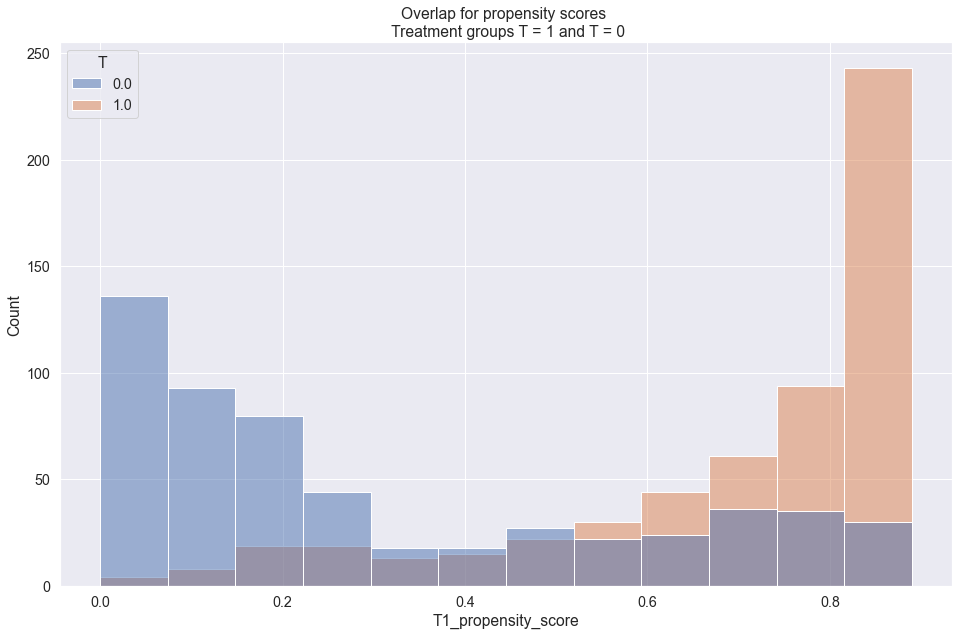

In [24]:
# Checking the overlap of ps for control and treatment using histogram
sns.histplot(data=merge1_0, x='T1_propensity_score', hue='T').set_title('Overlap for propensity scores \n Treatment groups T = 1 and T = 0') 


Plotting propensity scores as a function of Age category, Treatment group is T = 1 and Control group is T = 0 

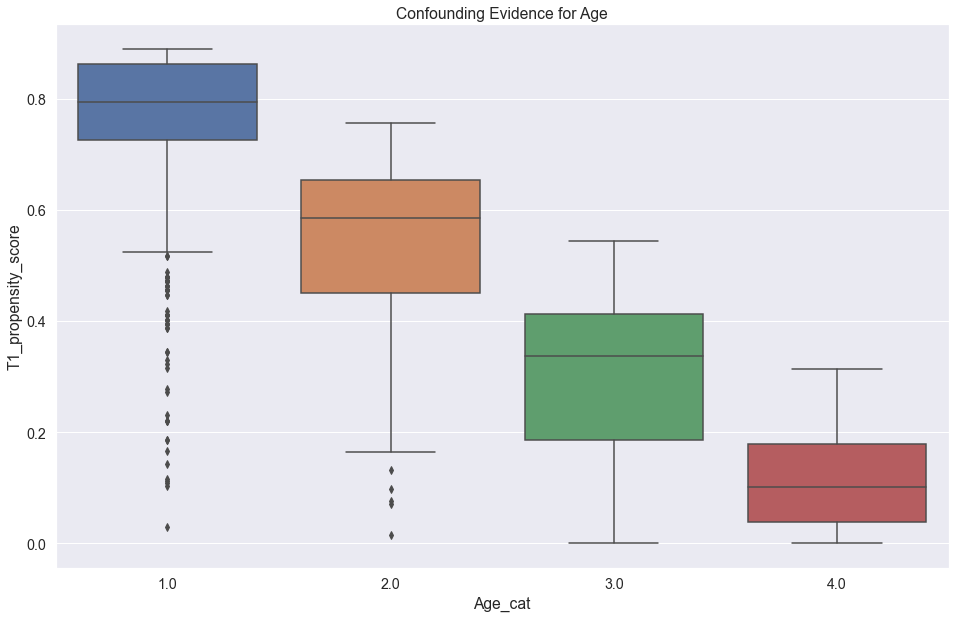

In [25]:
sns.boxplot(x="Age_cat", y="T1_propensity_score", data=merge1_0)
plt.title("Confounding Evidence for Age");

Plotting propensity scores as a function of BMI category, Treatment group is T = 1 and Control group is T = 0 

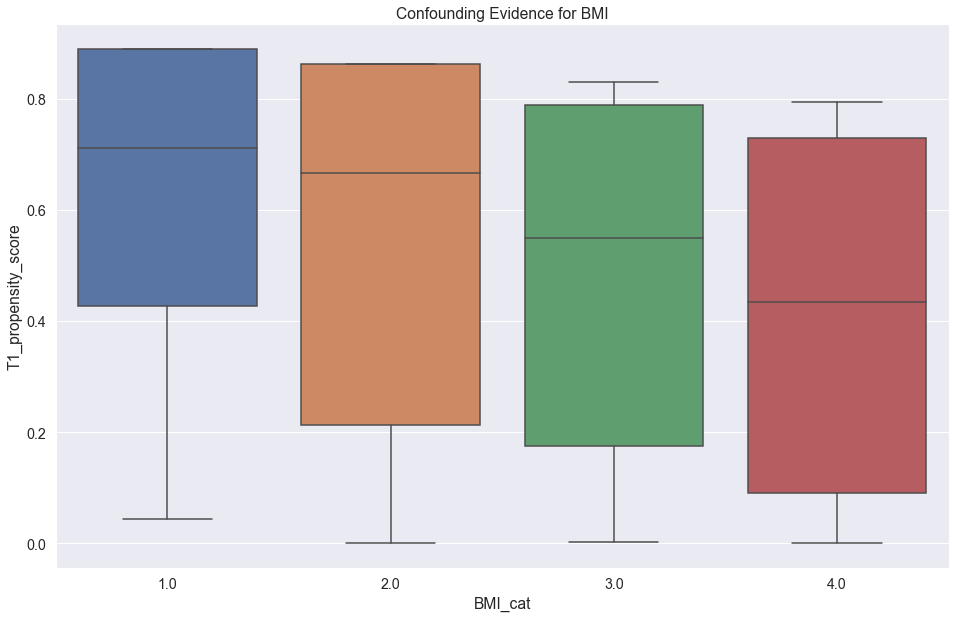

In [26]:
sns.boxplot(x="BMI_cat", y="T1_propensity_score", data=merge1_0)
plt.title("Confounding Evidence for BMI");

Plotting propensity scores as a function of IVF Number, Treatment group is T = 1 and Control group is T = 0 

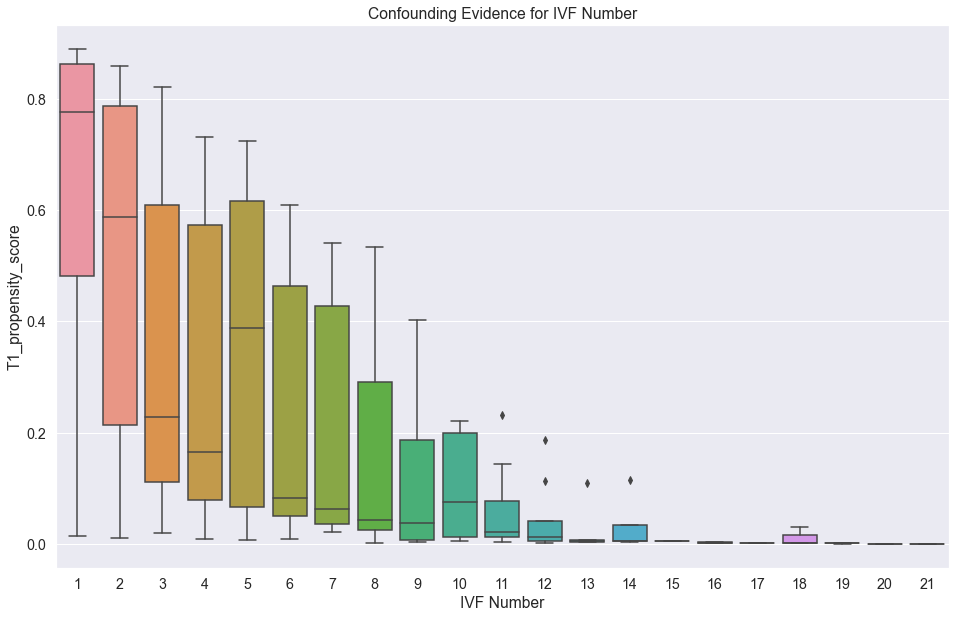

In [27]:
sns.boxplot(x="IVF Number", y="T1_propensity_score", data=merge1_0)
plt.title("Confounding Evidence for IVF Number");

Plotting propensity scores as a function of Failed Pregnancies, Treatment group is T = 1 and Control group is T = 0 

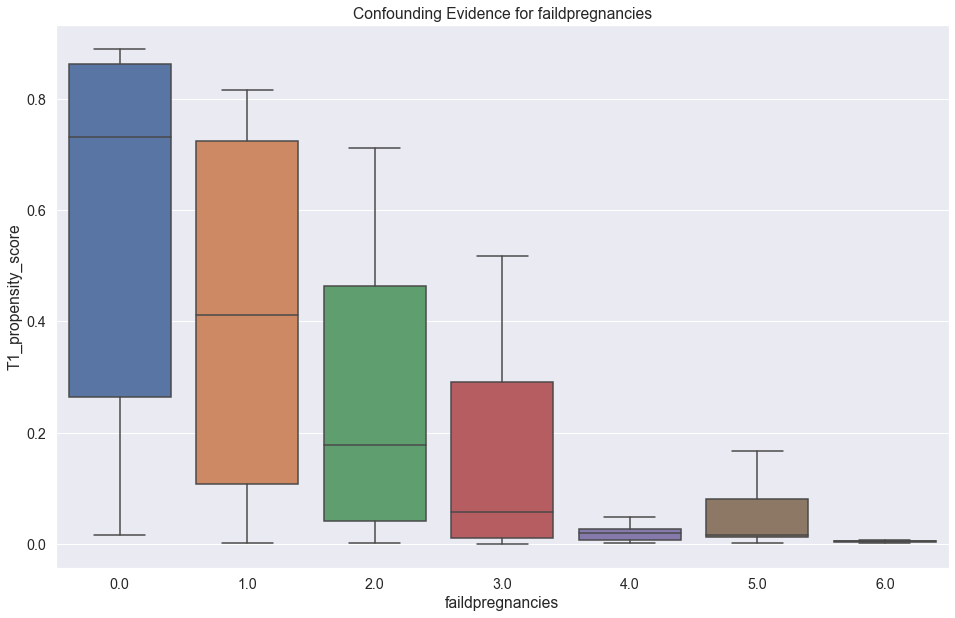

In [28]:
sns.boxplot(x="faildpregnancies", y="T1_propensity_score", data=merge1_0)
plt.title("Confounding Evidence for faildpregnancies");

# Matching Implementation


In [29]:
## calculate the logit of the propensity score for matching

In [30]:
def logit(p):
    logit_value = math.log(p / (1-p))
    return logit_value

merge1_0['T1_ps_logit'] = merge1_0['T1_propensity_score'].apply(lambda x: logit(x))



#Use Nearerst Neighbors to identify matching candidates. Then perform 1-to-1 matching by isolating/identifying groups of (T=1,T=0).

#Caliper: 25% of standart deviation of logit(propensity score)
caliper = np.std(merge1_0['T1_ps_logit']) * 0.25

print('\nCaliper (radius) is: {:.4f}\n'.format(caliper))


merge1_0=merge1_0.reset_index()

knn = NearestNeighbors(n_neighbors=merge1_0.shape[0]-1 , p = 2, radius=caliper)
knn.fit(merge1_0[['T1_ps_logit']].to_numpy())



#For each data point (based on the logit propensity score) obtain all nearest matches. This is regardless of their treatment status.
# Common support distances and indexes

distances , neighbor_indexes = knn.kneighbors(
    merge1_0[['T1_ps_logit']].to_numpy(), \
    n_neighbors=merge1_0.shape[0]-1)



valid_indexes = merge1_0.index.values  # get a list of valid index values
matched_control = []

# approx 45 seconds run time #
for current_index in valid_indexes:
    row = merge1_0.loc[current_index]
    if row['T'] == 0:
        merge1_0.loc[current_index, 'matched'] = np.nan
    else:
        for idx in neighbor_indexes[current_index, :]:# מציאת שכן מקבוצת טיפול נגדית 
            if (current_index != idx) and (idx in valid_indexes) and (merge1_0.loc[idx]['T'] == 0):
                if idx not in matched_control:
                    merge1_0.loc[current_index, 'matched'] = idx
                    matched_control.append(idx)
                    break
print("done")




Caliper (radius) is: 0.4940

done


In [31]:
print('total observations in treatment 1:', len(merge1_0[merge1_0['T']==1]))
print('total matched observations in control 0:', len(matched_control))

total observations in treatment 1: 572
total matched observations in control 0: 562


In [32]:
# control have no match
treatment_matched = merge1_0.dropna(subset=['matched'])  # drop not matched

# matched control observation indexes
control_matched_idx = treatment_matched.matched
control_matched_idx = control_matched_idx.astype(int)  # change to int
control_matched_1_0 = merge1_0.loc[control_matched_idx, :]  # select matched control observations

# combine the matched treatment and control
df_matched_1_0 = pd.concat([treatment_matched, control_matched_1_0])

df_matched_1_0['T'].value_counts()

#matched control and treatment
df_matched_control_1_0 = df_matched_1_0[df_matched_1_0['T']==0]
df_matched_treatment_1_0 = df_matched_1_0[df_matched_1_0['T']==1]
df_matched_control_1_0
df_matched_treatment_1_0

,index,BMI,IVF Number,Age,T,Pregnant,BMI_cat,Age_cat,faildpregnancies,T1_propensity_score,T1_ps_logit,matched
0,2,28.888889,5,28.361396,1.0,0,3.0,1.0,0.0,0.616980,0.476749,705.0
1,3,28.888889,6,28.561259,1.0,0,3.0,1.0,0.0,0.549215,0.197501,573.0
2,5,28.888889,9,29.259411,1.0,0,3.0,1.0,0.0,0.345191,-0.640245,715.0
3,6,28.888889,11,29.574264,1.0,0,3.0,1.0,0.0,0.231699,-1.198742,630.0
4,7,28.888889,12,29.826146,1.0,0,3.0,1.0,0.0,0.185731,-1.477990,738.0
...,...,...,...,...,...,...,...,...,...,...,...,...
557,6462,32.467532,1,36.725530,1.0,1,4.0,2.0,1.0,0.450320,-0.199378,1078.0
558,6476,24.772097,1,36.856947,1.0,0,2.0,2.0,0.0,0.707889,0.885153,1079.0
559,6498,30.043262,4,30.171116,1.0,0,4.0,1.0,0.0,0.624611,0.509168,770.0
560,6506,22.582709,1,26.042437,1.0,0,2.0,1.0,0.0,0.863016,1.840573,1080.0


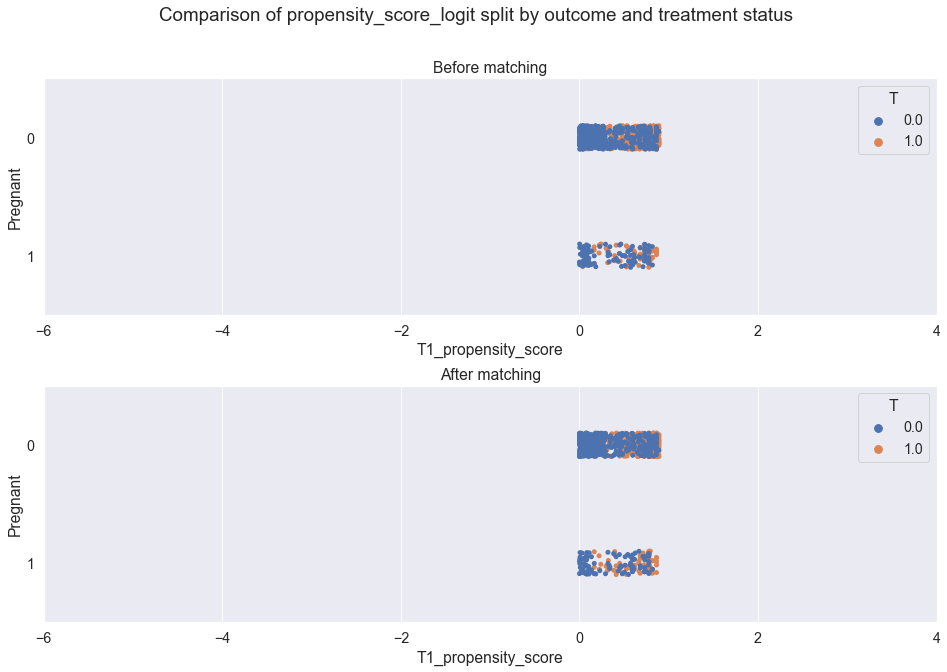

In [33]:
#Checking distribution of propensity score before and after matching #
fig, ax = plt.subplots(2,1)
fig.suptitle('Comparison of {} split by outcome and treatment status'.format('propensity_score_logit'))
sns.stripplot(data = merge1_0, y = 'Pregnant', x = 'T1_propensity_score', hue = 'T', orient = 'h', ax = ax[0]).set(title = 'Before matching', xlim=(-6, 4))
sns.stripplot(data = df_matched_1_0, y = 'Pregnant', x = 'T1_propensity_score', hue = 'T', ax = ax[1] , orient = 'h').set(title = 'After matching', xlim=(-6, 4))
plt.subplots_adjust(hspace = 0.3)
plt.show()
#plt.rcParams["figure.figsize"] = (40,6.5)
fig.savefig("jitter_plot.png")

In [34]:
# As an effect size, Cohen's d is typically used to represent the magnitude of differences between two (or more) groups on a given variable, with larger values representing a greater differentiation between the two groups on that variable.
# we hope the effect sizes for features decrease after matching
# adapted from https://machinelearningmastery.com/effect-size-measures-in-python/

from numpy import mean
from numpy import var
from math import sqrt
 
# function to calculate Cohen's d for independent samples
def cohen_d(d1, d2):
	# calculate the size of samples
	n1, n2 = len(d1), len(d2)
	# calculate the variance of the samples
	s1, s2 = var(d1, ddof=1), var(d2, ddof=1)
	# calculate the pooled standard deviation
	s = sqrt(((n1 - 1) * s1 + (n2 - 1) * s2) / (n1 + n2 - 2))
	# calculate the means of the samples
	u1, u2 = mean(d1), mean(d2)
	# calculate the effect size
	return (u1 - u2) / s

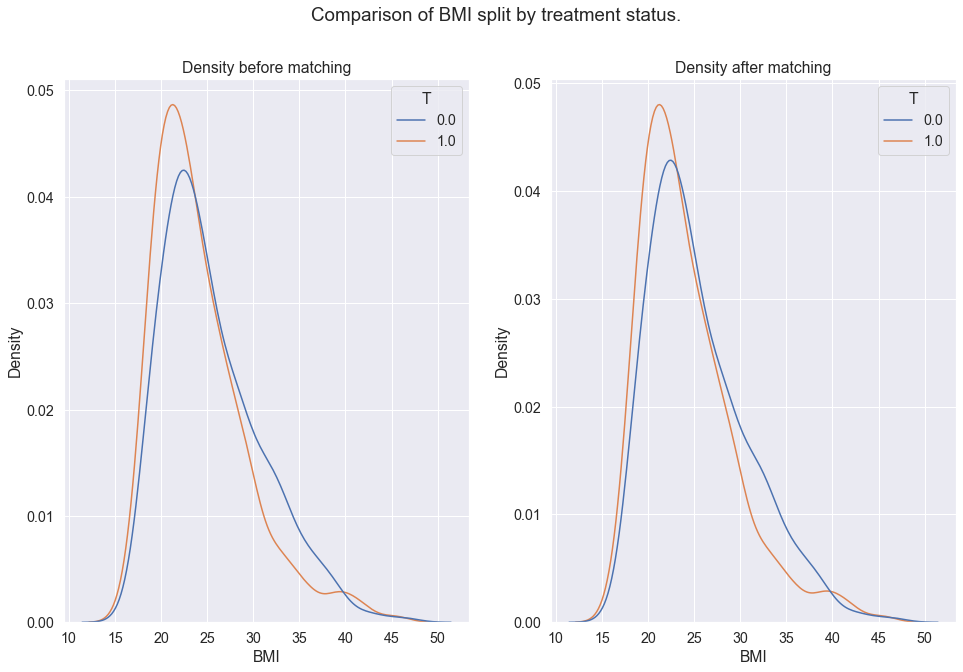

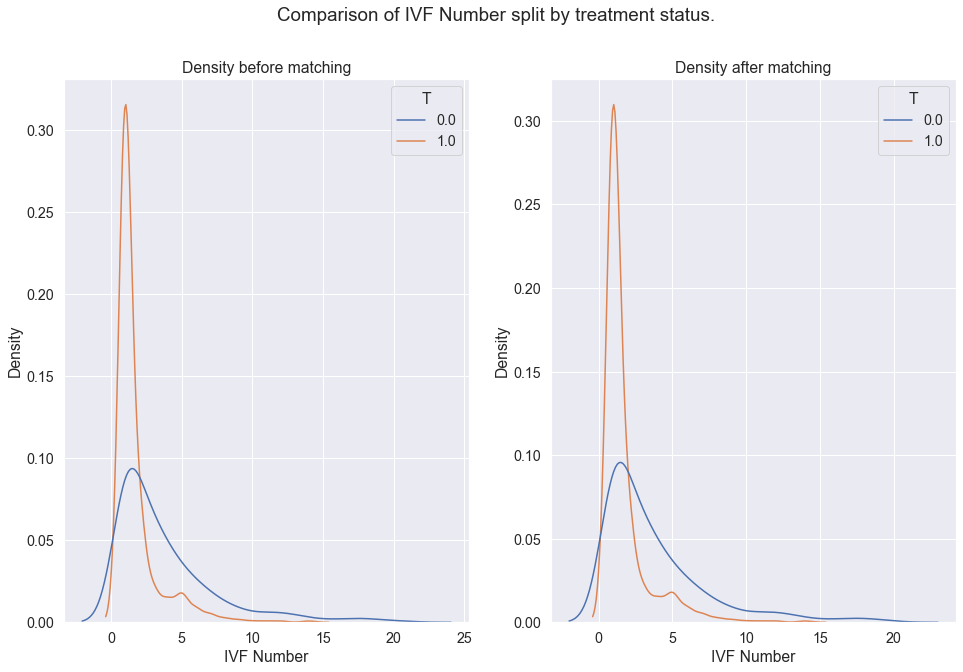

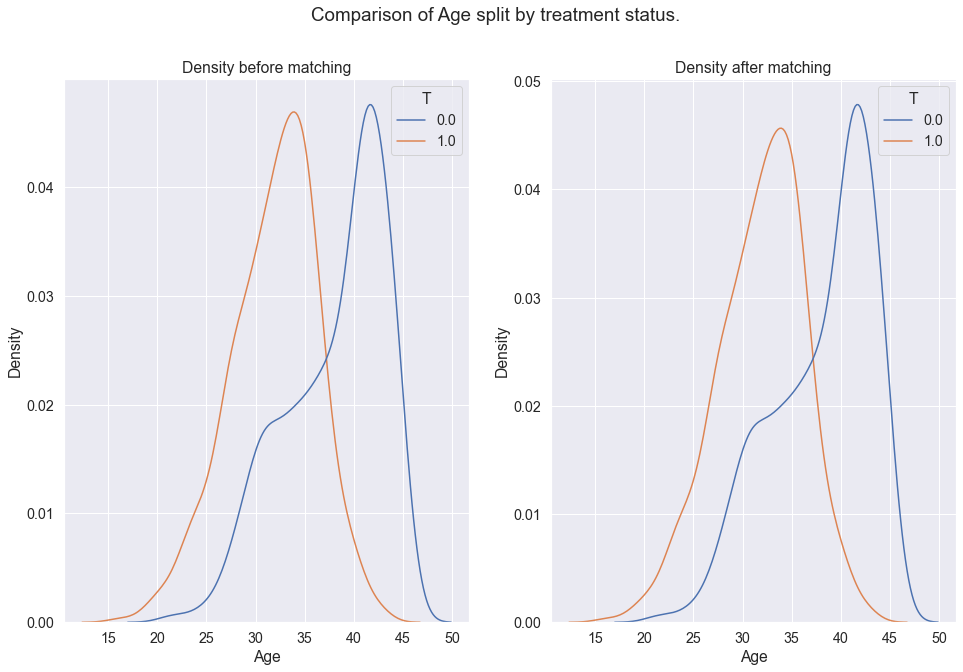

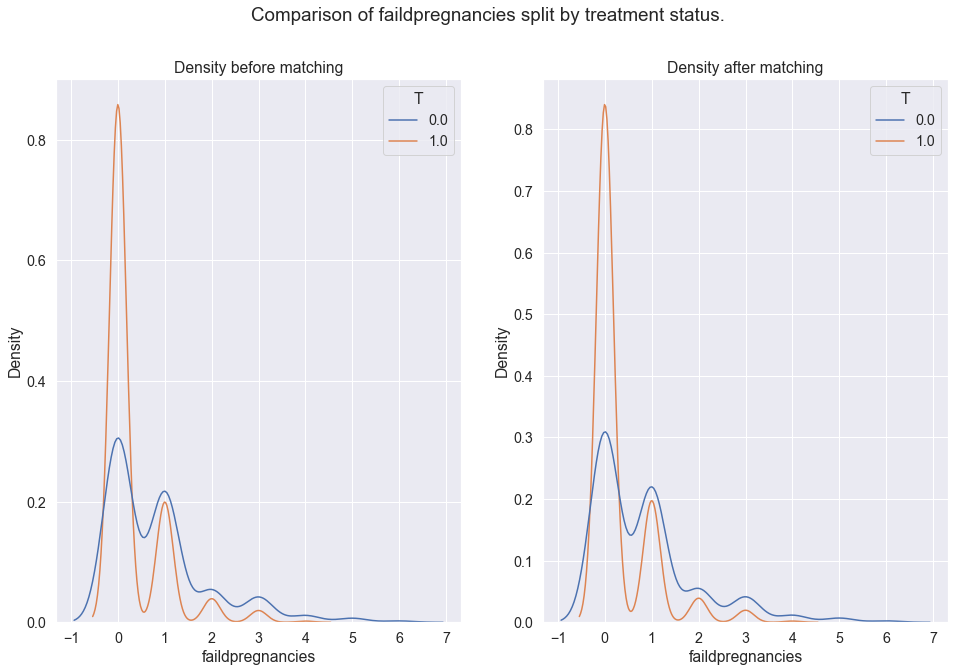

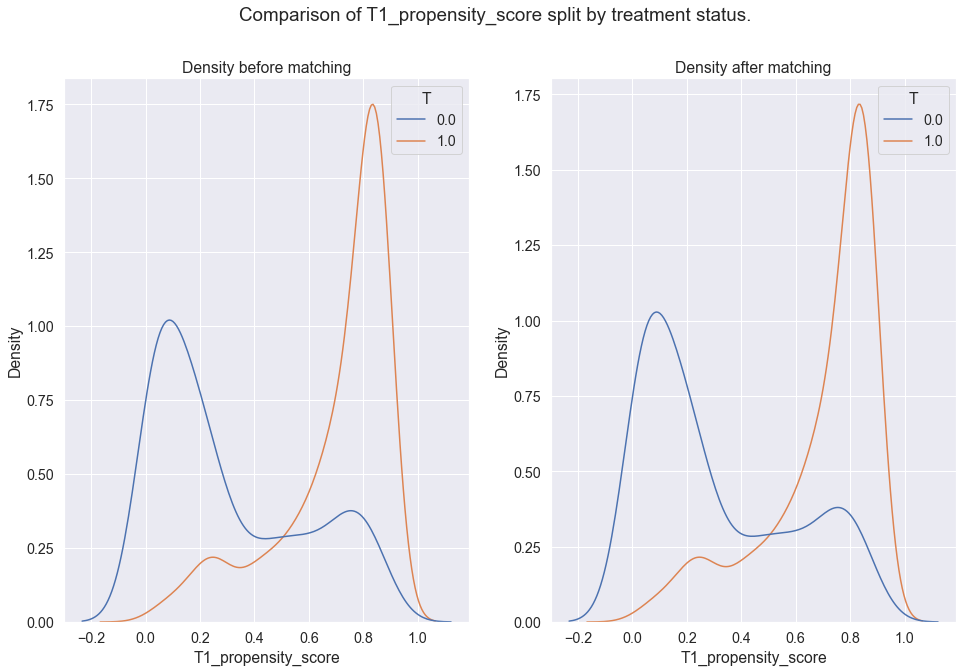

In [35]:
args = ['BMI','IVF Number','Age','faildpregnancies','T1_propensity_score']
#plt.rcParams["figure.figsize"] = (50,20)
def plot(arg):
    fig, ax = plt.subplots(1,2)
    fig.suptitle('Comparison of {} split by treatment status.'.format(arg))
    sns.kdeplot(data = merge1_0, x = arg, hue = 'T', ax = ax[0]).set(title='Density before matching')
    sns.kdeplot(data = df_matched_1_0, x = arg, hue = 'T',  ax = ax[1]).set(title='Density after matching')
    plt.show()
    fig.savefig("{}_comparison.png".format(arg))

for arg in args:
    plot(arg)

In [36]:
effect_sizes = []
cols = ['BMI','IVF Number','Age','faildpregnancies']

for cl in cols:
    _, p_before = ttest_ind(T1_control_0[cl], T1_treated[cl])
    _, p_after = ttest_ind(df_matched_control_1_0[cl], df_matched_treatment_1_0[cl])
    cohen_d_before = cohen_d(T1_treated[cl], T1_control_0[cl])
    cohen_d_after = cohen_d(df_matched_treatment_1_0[cl], df_matched_control_1_0[cl])
    effect_sizes.append([cl,'before', cohen_d_before, p_before])
    effect_sizes.append([cl,'after', cohen_d_after, p_after])
df_effect_sizes = pd.DataFrame(effect_sizes, columns=['feature', 'matching', 'effect_size', 'p-value'])
df_effect_sizes

,feature,matching,effect_size,p-value
0,BMI,before,-0.245861,3.708618e-05
1,BMI,after,-0.238126,6.985855e-05
2,IVF Number,before,-0.723653,3.330241e-32
3,IVF Number,after,-0.718118,1.779744e-31
4,Age,before,-1.309269,5.777838e-90
5,Age,after,-1.308738,4.684453e-89
6,faildpregnancies,before,-0.600080,4.673831e-23
7,faildpregnancies,after,-0.590778,3.186017e-22


<AxesSubplot:xlabel='effect_size', ylabel='feature'>

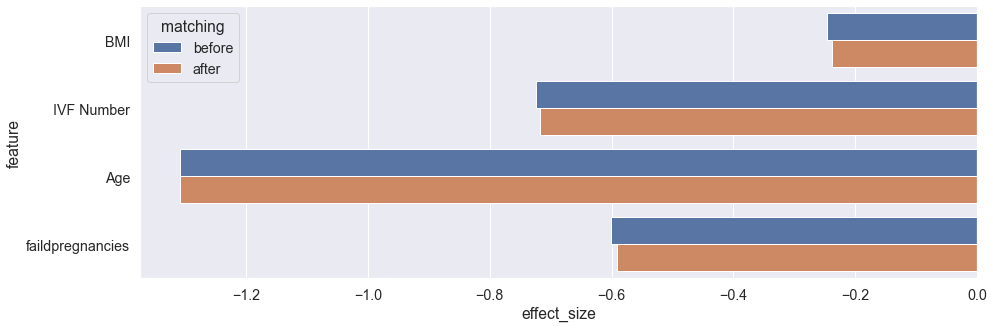

In [37]:
# discount_pct and featured are not significant, all other features are more balanced after matching
fig, ax = plt.subplots(figsize=(15, 5))
sns.barplot(data=df_effect_sizes, x='effect_size', y='feature', hue='matching', orient='h')

In [38]:
"""Matching did not change things all too much""" 

'Matching did not change things all too much'

# Average Treatement effect matching

In [39]:
overview_1_0 = df_matched_1_0[['Pregnant','T']].groupby(by = ['T']).aggregate([np.mean, np.var, np.std, 'count'])
print(overview_1_0)

     Pregnant                          
         mean       var       std count
T                                      
0.0  0.174377  0.144226  0.379772   562
1.0  0.117438  0.103831  0.322228   562


In [40]:
treated_outcome_1_0 = overview_1_0['Pregnant']['mean'][1]
treated_counterfactual_outcome_1_0 = overview_1_0['Pregnant']['mean'][0]
att_1_0 = treated_outcome_1_0 - treated_counterfactual_outcome_1_0
print('The Average Treatment Effect (ATE): {:.4f}'.format(abs(att_1_0)))
Point_estimate_matching = att_1_0

The Average Treatment Effect (ATE): 0.0569


#  ATE BY T -LEARNER 

In [41]:
np.random.seed(123)


m0 = ltb.LGBMRegressor(max_depth=2, min_child_samples=60)
m1 = ltb.LGBMRegressor(max_depth=2, min_child_samples=60)

m0.fit(merge1_0[merge1_0['T']==0][cols], merge1_0[merge1_0['T']==0]['Pregnant'])
m1.fit(merge1_0[merge1_0['T']==1][cols], merge1_0[merge1_0['T']==1]['Pregnant'])

# estimate the CATE
t_learner_cate_1_0 = m1.predict(merge1_0[cols]) - m0.predict(merge1_0[cols])

# print("The ATE by T learner :",t_learner_cate_1_0.mean())

Point_estimate_T = t_learner_cate_1_0.mean()

np.random.seed(123)
B = 500
ATE_ESTIMATOR=[]
nrow = merge1_0.shape[0]

for i in range(B):
    # Take a bootstrap sample
    bootstrap_sample = merge1_0.sample(n=nrow, replace=True, random_state=i) #n = 200 #
    m0 = ltb.LGBMRegressor(max_depth=2, min_child_samples=60 )
    m1 = ltb.LGBMRegressor(max_depth=2, min_child_samples=60)

    m0.fit(bootstrap_sample[bootstrap_sample['T']==0][cols], bootstrap_sample[bootstrap_sample['T']==0]['Pregnant'])
    m1.fit(bootstrap_sample[bootstrap_sample['T']==1][cols], bootstrap_sample[bootstrap_sample['T']==1]['Pregnant'])
    
    # estimate the CATE
    t_learner_cate_1_0 = m1.predict(merge1_0[cols]) - m0.predict(merge1_0[cols])
    ATE_T_1_0=t_learner_cate_1_0.mean()
    ATE_ESTIMATOR.append(ATE_T_1_0)
    
    
    
   
    
ATE_ESTIMATOR=list(np.array(ATE_ESTIMATOR))    
beta_list = sorted(ATE_ESTIMATOR, reverse = False)
CI_1_0_T_min = np.quantile(beta_list, 0.025)
CI_1_0_T_max = np.quantile(beta_list, 1-0.025)
# print("The credible interval:[", CI_1_min.round(3), CI_1_max.round(3) , "]")

print("Point estimate for ATE using  T-Learner:" , Point_estimate_T.round(4)) 
print("95% CI for ATE using T-Learner: [", CI_1_0_T_min.round(4), CI_1_0_T_max.round(4) , "]")


Point estimate for ATE using  T-Learner: 0.0004
95% CI for ATE using T-Learner: [ -0.0443 0.0507 ]


<AxesSubplot:title={'center':' Feature importance - Pregnant'}, xlabel='x', ylabel='y'>

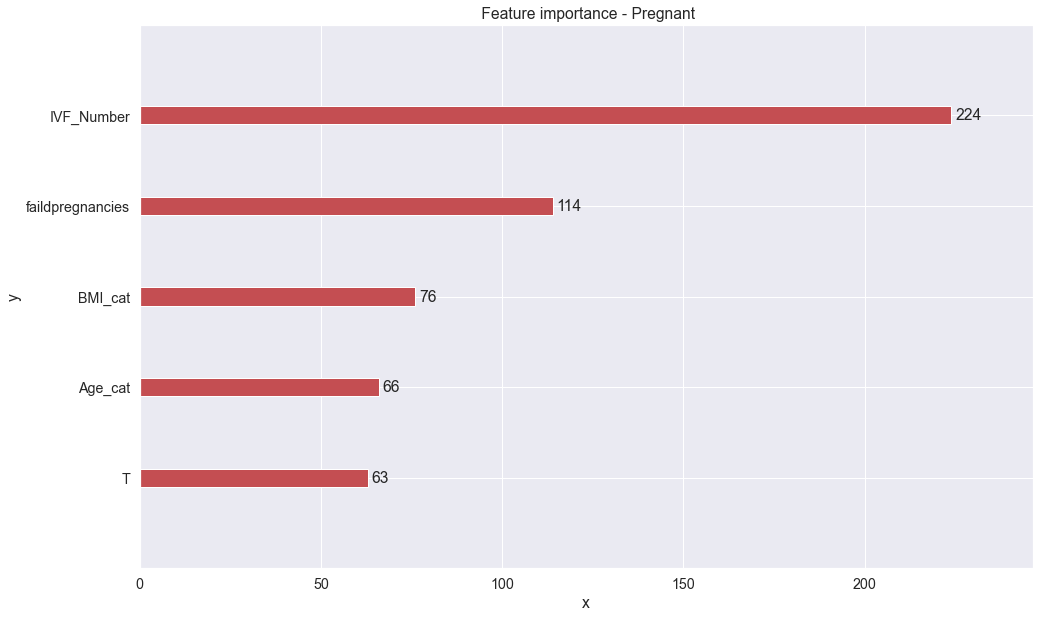

In [42]:
s_learner = ltb.LGBMRegressor(max_depth=3, min_child_samples=30)
cols_t=['BMI_cat','IVF Number','Age_cat','faildpregnancies','T']
s_learner.fit( new_data[cols_t], new_data['Pregnant']);

plot_importance(s_learner, color='r', title=' Feature importance - Pregnant', xlabel='x', ylabel='y')
# plot
#plt.bar(['IVF Number','faildpregnancies','BMI_cat','Age_cat','T'], s_learner.feature_importances_)
#plt.show()


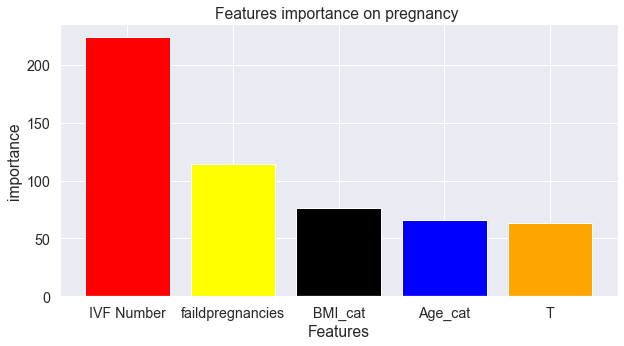

In [44]:
# creating data on which bar chart will be plot

x = ['IVF Number',  'faildpregnancies',
         'BMI_cat','Age_cat','T']
y = [224,114, 76, 66,63]
     
# setting figure size by using figure() function
plt.figure(figsize = (10, 5))
     
# making the bar chart on the data
plt.bar(x, y,color = ['red', 'yellow', 'black', 'blue', 'orange'])
     

     
# giving title to the plot
plt.title("Features importance on pregnancy ")
     
# giving X and Y labels
plt.xlabel("Features")
plt.ylabel("importance")
     
# visualizing the plot
plt.show()

<AxesSubplot:title={'center':'t'}, xlabel='x', ylabel='y'>

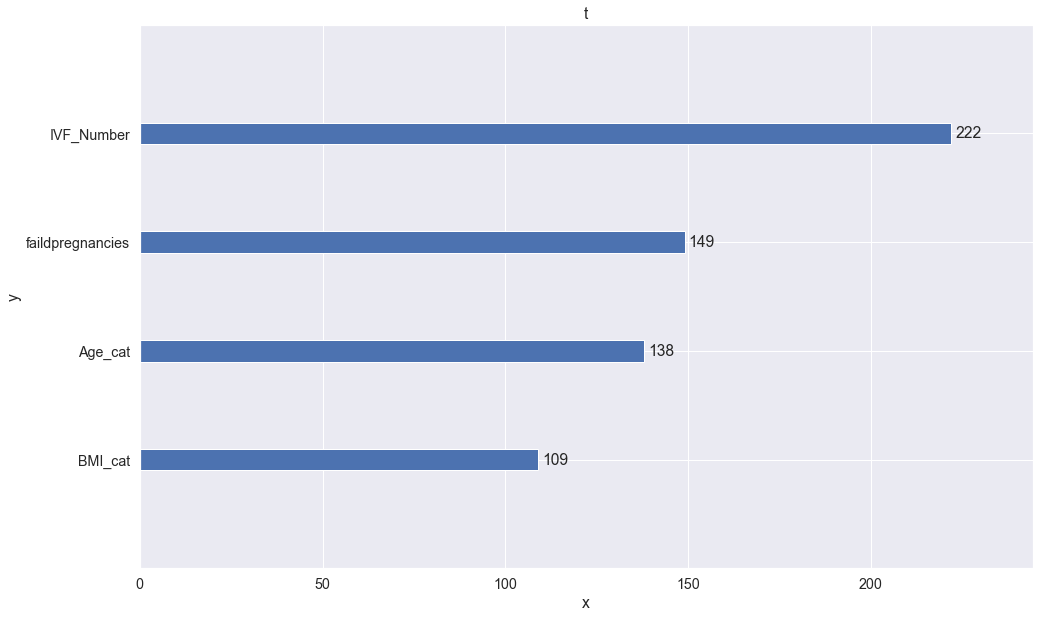

In [45]:
s_learner = ltb.LGBMRegressor(max_depth=3, min_child_samples=30)
cols_t=['BMI_cat','IVF Number','Age_cat','faildpregnancies']
s_learner.fit( new_data[cols_t],new_data['T']);
plot_importance(s_learner, color='b', title='t', xlabel='x', ylabel='y')

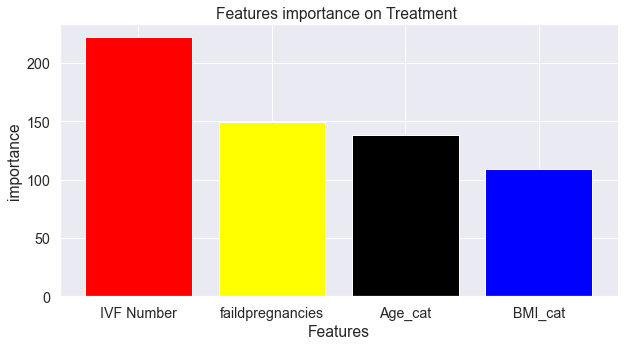

In [47]:
# creating data on which bar chart will be plot

x = ['IVF Number',  'faildpregnancies',
         'Age_cat','BMI_cat']
y = [222, 149, 138,109]
     
# setting figure size by using figure() function
plt.figure(figsize = (10, 5))
     
# making the bar chart on the data
plt.bar(x, y,color = ['red', 'yellow', 'black', 'blue', 'orange'])
     

     
# giving title to the plot
plt.title("Features importance on Treatment ")
     
# giving X and Y labels
plt.xlabel("Features")
plt.ylabel("importance")
     
# visualizing the plot
plt.show()

# S-Learner

In [48]:
# S-Learner groups 1 and 0 #

np.random.seed(123)
s_learner = ltb.LGBMRegressor(max_depth=3, min_child_samples=30)
cols_t=['BMI_cat','IVF Number','Age_cat','faildpregnancies','T']
s_learner.fit( merge1_0[cols_t], merge1_0['Pregnant']);
predict_under_treatment=s_learner.predict(merge1_0[cols].assign(**{'T': 1}))
predict_under_control=s_learner.predict(merge1_0[cols].assign(**{'T': 0}))
sum_treatment=(predict_under_treatment-predict_under_control)
ATE_S_1_0=sum_treatment.mean()
Point_estimate_S = ATE_S_1_0

np.random.seed(123)
B = 500
S_ATE_ESTIMATOR1=[]
nrow = merge1_0.shape[0]

for i in range(B):
    # Take a bootstrap sample
    bootstrap_sample = merge1_0.sample(n=nrow, replace=True, random_state=i) #n = 200 #
    s_learner = ltb.LGBMRegressor(max_depth=3, min_child_samples=30)
    cols_t=['BMI_cat','IVF Number','Age_cat','faildpregnancies','T']
    s_learner.fit( bootstrap_sample[cols_t], bootstrap_sample['Pregnant']);
    predict_under_treatment=s_learner.predict(bootstrap_sample[cols].assign(**{'T': 1}))
    predict_under_control=s_learner.predict(bootstrap_sample[cols].assign(**{'T': 0}))
    sum_treatment=(predict_under_treatment-predict_under_control)
    ATE_S_1_0=sum_treatment.mean()

    S_ATE_ESTIMATOR1.append(ATE_S_1_0)
    
S_ATE_ESTIMATOR1=list(np.array(S_ATE_ESTIMATOR1))    
beta_list = sorted(S_ATE_ESTIMATOR1, reverse = False)
CI_1_0_S_min = np.quantile(beta_list, 0.025)
CI_1_0_S_max = np.quantile(beta_list, 1-0.025)


print("Point estimate for ATE using S-Learner:" , Point_estimate_S.round(4)) 
print("95% CI for ATE using S-Learner: [", CI_1_0_S_min.round(4), CI_1_0_S_max.round(4) , "]")



Point estimate for ATE using S-Learner: 0.0129
95% CI for ATE using S-Learner: [ -0.0484 0.0787 ]


# ATE  for treatment 1 control 0 by IPW 

In [49]:
ATE_IPW_1_0=0

for idx, row in merge1_0.iterrows():
    sum_1=(row['T']*row['Pregnant'])/row['T1_propensity_score'] # in case T=1
    sum_0=(1-row['T'])*row['Pregnant']/(1-row['T1_propensity_score'])
    ATE_IPW_1_0+=sum_1 - sum_0
ATE_IPW_1_0=ATE_IPW_1_0/merge1_0.shape[0]
print(ATE_IPW_1_0)


# Bootstrap 95% CI for IPW estimator # 

Point_estimate_IPW = ATE_IPW_1_0

np.random.seed(123)
B = 500
IPW_ESTIMATORS=[]
nrow = merge1_0.shape[0]
# sampledCases = np.int_(np.random.uniform(0,nrow,nrow))

# sampledData = merge1_0.iloc[sampledCases]
# display(sampledData)
for i in range(B):
    # Take a bootstrap sample
    sampledCases = np.int_(np.random.uniform(0,nrow,nrow))
    bootstrap_sample = merge1_0.iloc[sampledCases].copy()
    ATE_IPW_1_0=0

    for idx, row in bootstrap_sample.iterrows():
        sum_1=(row['T']*row['Pregnant'])/row['T1_propensity_score'] # in case T=1
        sum_0=(1-row['T'])*row['Pregnant']/(1-row['T1_propensity_score'])
        ATE_IPW_1_0+=sum_1 - sum_0
    ATE_IPW_1_0=ATE_IPW_1_0/bootstrap_sample.shape[0]

    IPW_ESTIMATORS.append(ATE_IPW_1_0.mean())
    
    
IPW_ESTIMATORS=list(np.array(IPW_ESTIMATORS))    
beta_list = sorted(IPW_ESTIMATORS, reverse = False)
CI_1_0_IPW_min = np.quantile(beta_list, 0.025)
CI_1_0_IPW_max = np.quantile(beta_list, 1-0.025)
print("Point estimate for ATE using IPW:" , Point_estimate_IPW.round(3)) 
print("95% CI for ATE using IPW: [", CI_1_0_IPW_min.round(3) , CI_1_0_IPW_max.round(3) , "]")



-0.04109229537751929
Point estimate for ATE using IPW: -0.041
95% CI for ATE using IPW: [ -0.106 0.036 ]


#  X LEARNER

In [50]:
# Machine learning model
from lightgbm import LGBMRegressor
from xgboost import XGBClassifier

In [51]:
# Keep only the treated units
df_treated = merge1_0[merge1_0['T'] == 1].copy()
# Features
features_treated = df_treated[['BMI_cat','IVF Number','Age_cat','faildpregnancies','T']]
# Dependent variable
y_treated = df_treated[['Pregnant']]
# Print data shape
print(f'The feature maxtrix for the treated has {features_treated.shape[0]} records and {features_treated.shape[1]} features.')
print(f'The dependent variable for the treated has {y_treated.shape[0]} records.')
# Keep only the control units
df_control = merge1_0[merge1_0['T'] == 0].copy()
# Features
features_control = df_control[['BMI_cat','IVF Number','Age_cat','faildpregnancies','T']]
# Dependent variable
y_control = df_control[['Pregnant']]
# Print data shape
print(f'The feature maxtrix for the control has {features_control.shape[0]} records and {features_control.shape[1]} features.')
print(f'The dependent variable for the control has {y_control.shape[0]} records.')

The feature maxtrix for the treated has 572 records and 5 features.
The dependent variable for the treated has 572 records.
The feature maxtrix for the control has 563 records and 5 features.
The dependent variable for the control has 563 records.


In [52]:
# Features for all the samples
features = merge1_0[['BMI_cat','IVF Number','Age_cat','faildpregnancies','T']].copy()

In [53]:

# X-learner stage one model for the treated
s1_treated = LGBMRegressor().fit(features_treated, y_treated)
# X-learner stage one model for the control
s1_control = LGBMRegressor().fit(features_control, y_control)

In [54]:
# Predictions on the control group using the treated model
s1_treated_predict = s1_treated.predict(features_control)
# Predictions on the treated group using the control model
s1_control_predict = s1_control.predict(features_treated)

In [55]:
# Create a column for the predicted outcomes
df_treated['predicted_outcome'] = s1_control_predict
# Create a column for the imputed ite
df_treated['imputed_ite'] =  df_treated.apply(lambda row: row['Pregnant'] - row.predicted_outcome, axis = 1)
# Create a column for the predicted outcomes
df_control['predicted_outcome'] = s1_treated_predict
# Create a column for the imputed ite
df_control['imputed_ite'] =  df_control.apply(lambda row: row.predicted_outcome - row['Pregnant'], axis = 1)

In [56]:
# Light GBM model for the treated
s2_treated = LGBMRegressor().fit(features_treated, df_treated['imputed_ite'])
# Light GBM model for the control
s2_control = LGBMRegressor().fit(features_control, df_control['imputed_ite'])

In [57]:
# Predictions using the treated model
s2_treated_predict = s2_treated.predict(features)
# Save the prediction results as a colum in the dataframe
merge1_0['s2_treated_predict'] = s2_treated_predict
# Predictions using the control model
s2_control_predict = s2_control.predict(features)
# Save the prediction results as a colum in the dataframe
merge1_0['s2_control_predict'] = s2_control_predict

In [58]:
# Train the XGBoost model
xgb = XGBClassifier(seed=0, eval_metric='mlogloss').fit(features,merge1_0[['T']])
# Make predictions
xgb_predict_prob = xgb.predict_proba(features)[:,1]
# Save the prediction results as a colum in the dataframe
merge1_0['treatment_propensity_score'] = xgb_predict_prob


In [59]:
# Calculate the weighted ITE
merge1_0['ITE'] = merge1_0.apply(lambda row: row.treatment_propensity_score*row.s2_control_predict + (1-row.treatment_propensity_score)*row.s2_treated_predict, axis=1)
# Take a look at the data
merge1_0.head()

,index,BMI,IVF Number,Age,T,Pregnant,BMI_cat,Age_cat,faildpregnancies,T1_propensity_score,T1_ps_logit,matched,s2_treated_predict,s2_control_predict,treatment_propensity_score,ITE
0,2,28.888889,5,28.361396,1.0,0,3.0,1.0,0.0,0.616980,0.476749,705.0,-0.048440,-0.071989,0.99839,-0.071952
1,3,28.888889,6,28.561259,1.0,0,3.0,1.0,0.0,0.549215,0.197501,573.0,0.177526,0.145266,0.99839,0.145318
2,5,28.888889,9,29.259411,1.0,0,3.0,1.0,0.0,0.345191,-0.640245,715.0,0.177526,0.214249,0.99839,0.214190
3,6,28.888889,11,29.574264,1.0,0,3.0,1.0,0.0,0.231699,-1.198742,630.0,0.177526,0.180118,0.99839,0.180114
4,7,28.888889,12,29.826146,1.0,0,3.0,1.0,0.0,0.185731,-1.477990,738.0,0.177526,0.152004,0.99839,0.152045


array([[<AxesSubplot:title={'center':'ITE'}>]], dtype=object)

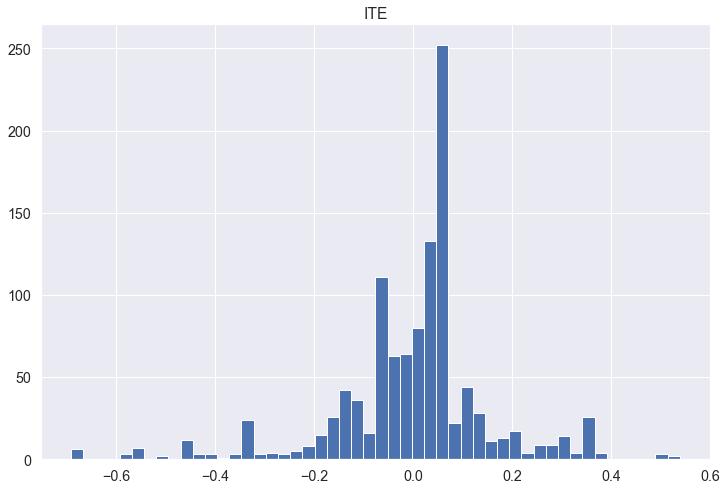

In [60]:
# visualization
merge1_0.hist(column ='ITE', bins=50, grid=True, figsize=(12, 8))

In [61]:
 merge1_0['ITE'].mean()

0.0002554063598692369

In [62]:
# Calculate ATE
Point_estimate_X = merge1_0[['ITE']].mean()
# Print out results
print(f'The average treatment effect (ATE) is {Point_estimate_X[0]:}')

The average treatment effect (ATE) is 0.0002554063598692369


### BOOSTRAP FOR X LEARNER 

In [63]:
np.random.seed(123)
B = 500
ATE_ESTIMATOR_X=[]
nrow = merge1_0.shape[0]

for i in range(B):
    # Take a bootstrap sample
    bootstrap_sample = merge1_0.sample(n=nrow, replace=True, random_state=i) #n = 200 #
    # Keep only the treated units
    df_treated = bootstrap_sample[bootstrap_sample['T'] == 1].copy()
    # Features
    features_treated = df_treated[['BMI_cat','IVF Number','Age_cat','faildpregnancies','T']]
    # Dependent variable
    y_treated = df_treated[['Pregnant']]
    # Keep only the control units
    df_control = bootstrap_sample[bootstrap_sample['T'] == 0].copy()
    # Features
    features_control = df_control[['BMI_cat','IVF Number','Age_cat','faildpregnancies','T']]
    # Dependent variable
    y_control = df_control[['Pregnant']]
    # X-learner stage one model for the treated
    s1_treated = LGBMRegressor().fit(features_treated, y_treated)
    # X-learner stage one model for the control
    s1_control = LGBMRegressor().fit(features_control, y_control)
    
    # Predictions on the control group using the treated model
    s1_treated_predict = s1_treated.predict(features_control)
    # Predictions on the treated group using the control model
    s1_control_predict = s1_control.predict(features_treated)
    # Features for all the samples
    features = bootstrap_sample[['BMI_cat','IVF Number','Age_cat','faildpregnancies','T']].copy()
    # Create a column for the predicted outcomes
    df_treated['predicted_outcome'] = s1_control_predict
    # Create a column for the imputed ite
    df_treated['imputed_ite'] =  df_treated.apply(lambda row: row['Pregnant'] - row.predicted_outcome, axis = 1)
    # Create a column for the predicted outcomes
    df_control['predicted_outcome'] = s1_treated_predict
    # Create a column for the imputed ite
    df_control['imputed_ite'] =  df_control.apply(lambda row: row.predicted_outcome - row['Pregnant'], axis = 1)

    # Light GBM model for the treated
    s2_treated = LGBMRegressor( ).fit(features_treated, df_treated['imputed_ite'])
    # Light GBM model for the control
    s2_control = LGBMRegressor( ).fit(features_control, df_control['imputed_ite'])

    
   
    # Predictions using the treated model
    s2_treated_predict = s2_treated.predict(features)
    # Save the prediction results as a colum in the dataframe
    bootstrap_sample['s2_treated_predict'] = s2_treated_predict
    # Predictions using the control model
    s2_control_predict = s2_control.predict(features)
    # Save the prediction results as a colum in the dataframe
    bootstrap_sample['s2_control_predict'] = s2_control_predict
    
    # Train the XGBoost model
    xgb = XGBClassifier(seed=0, eval_metric='rmse' ).fit(features,bootstrap_sample[['T']])
    # Make predictions
    xgb_predict_prob = xgb.predict_proba(features)[:,1]
    # Save the prediction results as a colum in the dataframe
    bootstrap_sample['treatment_propensity_score'] = xgb_predict_prob
    # Calculate the weighted ITE
    bootstrap_sample['ITE'] = bootstrap_sample.apply(lambda row: row.treatment_propensity_score*row.s2_control_predict + (1-row.treatment_propensity_score)*row.s2_treated_predict, axis=1)
    
    # estimate the ATE
    ATE = bootstrap_sample[['ITE']].mean()
    ATE_ESTIMATOR_X.append(ATE[0])
    
    
    
   
    
ATE_ESTIMATOR_X=list(np.array(ATE_ESTIMATOR_X))    
beta_list = sorted(ATE_ESTIMATOR_X, reverse = False)
CI_1_0_X_min = np.quantile(beta_list, 0.025)
CI_1_0_X_max = np.quantile(beta_list, 1-0.025)
# print("The credible interval:[", CI_1_min.round(3), CI_1_max.round(3) , "]")

print("Point estimate for ATE using  X-Learner:" , Point_estimate_X.round(4)) 
print("95% CI for ATE using X-Learner: [", CI_1_0_X_min.round(4), CI_1_0_X_max.round(4) , "]")

Point estimate for ATE using  X-Learner: ITE    0.0003
dtype: float64
95% CI for ATE using X-Learner: [ -0.0524 0.0534 ]


In [64]:
ATE_no_covariants1_0=merge1_0[['Pregnant','T']].groupby(by = ['T']).aggregate([np.mean, np.var, np.std, 'count'])

ATE_no_covariants1_0=ATE_no_covariants1_0[("Pregnant","mean")][1] - ATE_no_covariants1_0[("Pregnant","mean")][0]
print("Naive ATE for treatment group T = 1 and control group T = 0:",ATE_no_covariants1_0 )


Naive ATE for treatment group T = 1 and control group T = 0: -0.055186376678383775


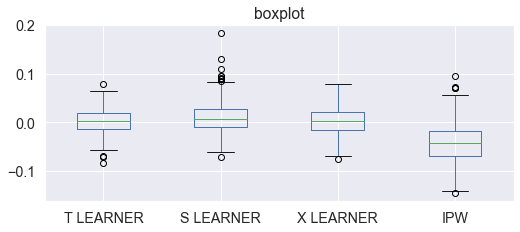

In [65]:

# Set the figure size
plt.rcParams["figure.figsize"] = [7.50, 3.50]
plt.rcParams["figure.autolayout"] = True

# Pandas dataframe
data = pd.DataFrame({"T LEARNER": ATE_ESTIMATOR, "S LEARNER":S_ATE_ESTIMATOR1,"X LEARNER":ATE_ESTIMATOR_X,"IPW": IPW_ESTIMATORS})

# Plot the dataframe
kx = data[['T LEARNER', 'S LEARNER',"X LEARNER","IPW"]].plot(kind='box', title='boxplot')


# Display the plot
plt.show()


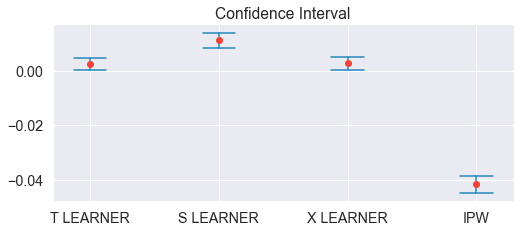

In [66]:


def plot_confidence_interval(x, values, z=1.96, color='#2187bb', horizontal_line_width=0.25):
    mean = statistics.mean(values)
    stdev = statistics.stdev(values)
    confidence_interval = z * stdev / sqrt(len(values))

    left = x - horizontal_line_width / 2
    top = mean - confidence_interval
    right = x + horizontal_line_width / 2
    bottom = mean + confidence_interval
    plt.plot([x, x], [top, bottom], color=color)
    plt.plot([left, right], [top, top], color=color)
    plt.plot([left, right], [bottom, bottom], color=color)
    plt.plot(x, mean, 'o', color='#f44336')

    return mean, confidence_interval


plt.xticks([1, 2, 3,4], ['T LEARNER', 'S LEARNER','X LEARNER' ,'IPW'])
plt.title('Confidence Interval')
plot_confidence_interval(1, ATE_ESTIMATOR)
plot_confidence_interval(2, S_ATE_ESTIMATOR1)
plot_confidence_interval(3, ATE_ESTIMATOR_X)
plot_confidence_interval(4, IPW_ESTIMATORS)

plt.show()

In [67]:
B = [Point_estimate_T,Point_estimate_S,Point_estimate_X ,Point_estimate_IPW]
print(B)

[0.0003785083984093969, 0.012872156705399722, ITE    0.000255
dtype: float64, -0.04109229537751929]


Text(0.5, 1.0, 'Confidence Interval')

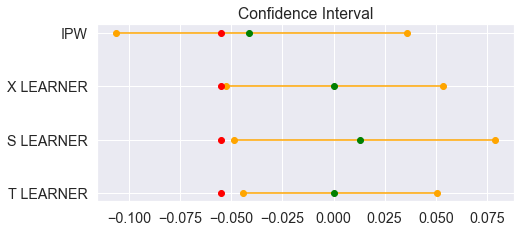

In [68]:

data_dict = {}
data_dict['category'] = ['T LEARNER','S LEARNER','X LEARNER','IPW']
data_dict['lower'] = [CI_1_0_T_min,CI_1_0_S_min,CI_1_0_X_min,CI_1_0_IPW_min]
data_dict['upper'] = [CI_1_0_T_max,CI_1_0_S_max,CI_1_0_X_max,CI_1_0_IPW_max]
data_dict['Estimator'] = [Point_estimate_T,Point_estimate_S,Point_estimate_X ,Point_estimate_IPW]
dataset = pd.DataFrame(data_dict)

for lower,upper,Estimator,y in zip(dataset['lower'],dataset['upper'],dataset['Estimator'],range(len(dataset))):
    #plt.plot((lower,mean,upper),(y,y,y),'ro-',color='orange')
    plt.plot((lower,upper),(y,y),'ro-',color='orange')
    plt.plot(Estimator,(y),'ro-',color='green',label='Estimator')
    plt.plot((ATE_no_covariants1_0),(y),'ro-',color='red',label='ATE NAIVE')
    

plt.yticks(range(len(dataset)),list(dataset['category']))
plt.title('Confidence Interval')

 

#plt.axhline(y = ATE_no_covariants1_0, color = 'r', linestyle = '-')
#plt.scatter([ATE_no_covariants1_0], [ATE_no_covariants1_0], color="red") # plotting single point



### Best guess for ATE between T = 0 and T = 1: Mean of all estimands 

In [69]:
ATE_1_0_mean = (Point_estimate_matching + Point_estimate_T + Point_estimate_S + Point_estimate_IPW)  / 4
ATE_1_0_mean 


-0.0211952830132674

# Treatment : T=2

# CONTROL:T=0

In [70]:
# Split the data into treatment and control groups for each medication
T2_treated = new_data[new_data['T'] == 2].copy()
T2_control_0 = new_data[new_data['T']  == 0].copy()


merge2_0=T2_treated.append(T2_control_0)
merge2_0=merge2_0.reset_index()

merge2_0.drop('index', inplace=True, axis=1)
merge2_0.drop('BMI', inplace=True, axis=1)#שימוש בקטגוריות
merge2_0.drop('Age', inplace=True, axis=1)

#  Checking for difference in covariates between treatment and control groups

In [71]:
merge2_0.groupby('T').mean()

,IVF Number,Pregnant,BMI_cat,Age_cat,faildpregnancies
T,,,,,
0.0,3.769094,0.174067,2.634103,2.889876,0.849023
2.0,2.413450,0.085928,2.554172,2.425903,0.519303


# Comparing Age variable 

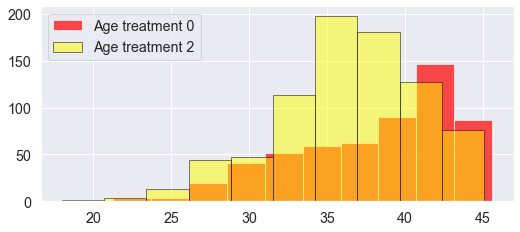

In [72]:
# plotting  age histogram for treatment 0
plt.hist(T2_control_0['Age'], label='Age treatment 0', alpha=.7, color='red')

# plotting treatment 2 age histogram
plt.hist(T2_treated['Age'], label="Age treatment 2", alpha=.5,
         edgecolor='black', color='yellow')

plt.legend()
 
# Showing the plot using plt.show()
plt.show()


In [73]:
# t-test for Age (dependent variable)
from scipy.stats import ttest_ind

print(T2_control_0['Age'].mean(), T2_treated['Age'].mean())

# compare samples
_, p = ttest_ind(T2_control_0['Age'], T2_treated['Age'])
print(f'p={p:.3f}')

# interpret
alpha = 0.05  # significance level
print("The age field of treatment 2 and 0 have:")
if p > alpha:
    print(' same distributions/same group mean (fail to reject H0 - we do not have enough evidence to reject H0)')
else:
    print('different distributions/different group mean (reject H0)')

38.101103529023035 36.488486450846835
p=0.000
The age field of treatment 2 and 0 have:
different distributions/different group mean (reject H0)


# Comparing BMI variable

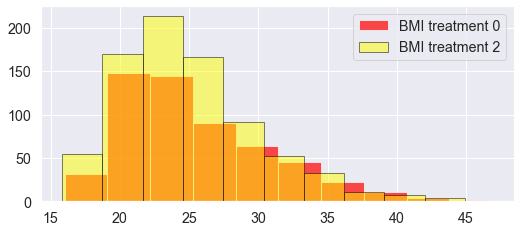

In [74]:
import matplotlib.pyplot as plt
 
# plotting treatment 0 BMI histogram
plt.hist(T2_control_0['BMI'], label='BMI treatment 0', alpha=.7, color='red')


# plotting treatment 2 BMI histogram
plt.hist(T2_treated['BMI'], label="BMI treatment 2", alpha=.5,
         edgecolor='black', color='yellow')

plt.legend()
 
# Showing the plot using plt.show()
plt.show()

# Histogram for Failed Pregnancies

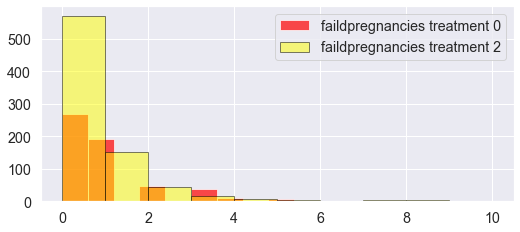

In [75]:
import matplotlib.pyplot as plt
 
# plotting treatment 0 faild Pregnancies histogram
plt.hist(T2_control_0['faildpregnancies'], label='faildpregnancies treatment 0', alpha=.7, color='red')

 
# plotting treatment 2 faild Pregnancies histogram
plt.hist(T2_treated['faildpregnancies'], label="faildpregnancies treatment 2", alpha=.5,
         edgecolor='black', color='yellow')

plt.legend()
 
# Showing the plot using plt.show()
plt.show()

In [76]:
#  t-test for faild Pregnancies (dependent variable)
from scipy.stats import ttest_ind

print(T2_control_0['faildpregnancies'].mean(), T2_treated['faildpregnancies'].mean())

# compare samples
_, p = ttest_ind(T2_control_0['faildpregnancies'], T2_treated['faildpregnancies'])
print(f'p={p:.3f}')

# interpret
alpha = 0.05  # significance level
print("The faild pregnancies field of treatment 2 and 0 have:")
if p > alpha:
    print(' same distributions/same group mean (fail to reject H0 - we do not have enough evidence to reject H0)')
else:
    print('different distributions/different group mean (reject H0)')

0.8490230905861457 0.5193026151930261
p=0.000
The faild pregnancies field of treatment 2 and 0 have:
different distributions/different group mean (reject H0)


# Comparing Number IVF 

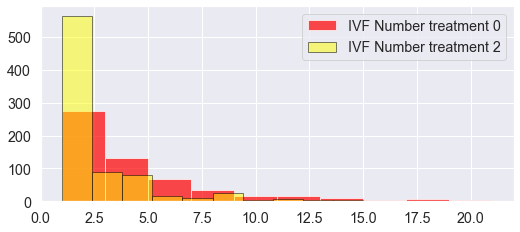

In [77]:
import matplotlib.pyplot as plt
 
# plotting treatment 0 IVF Number histogram
plt.hist(T2_control_0['IVF Number'], label='IVF Number treatment 0', alpha=.7, color='red')

# plotting treatment 2 IVF Number histogram
plt.hist(T2_treated['IVF Number'], label="IVF Number treatment 2", alpha=.5,
         edgecolor='black', color='yellow')

plt.legend()
 
# Showing the plot using plt.show()
plt.show()

# propensity scores

In [78]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression as lr

covariate_cols=['BMI_cat','IVF Number','Age_cat','faildpregnancies']
# Design pipeline to build the treatment estimator
pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('logistic_classifier', lr())# Train a logistic regression model to estimate propensity scores for each medication
])

pipe.fit(merge2_0[covariate_cols],merge2_0['T'])

Pipeline(steps=[('scaler', StandardScaler()),
                ('logistic_classifier', LogisticRegression())])

# prediction

In [79]:
T2_control_0['T2_propensity_score'] = pipe.predict_proba(T2_control_0[covariate_cols])[:, 1]
T2_treated['T2_propensity_score'] = pipe.predict_proba(T2_treated[covariate_cols])[:, 1]
merge2_0=T2_treated.append(T2_control_0)

In [80]:
predictions_binary = pipe.predict(merge2_0[covariate_cols])

In [81]:
from sklearn import metrics
T = merge2_0['T']
print('Accuracy of prediction: {:.4f}\n'.format(metrics.accuracy_score(T, predictions_binary)))
print(metrics.roc_auc_score(T, predictions_binary))

Accuracy of prediction: 0.6398

0.5906602461019843


# overlap of ps for control 0 and treatment 2 using histogram

Text(0.5, 1.0, 'Overlap for propensity scores \n Treatment groups T = 2 and T = 0')

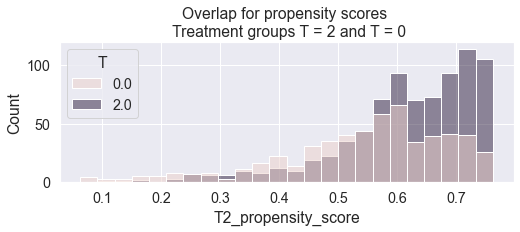

In [82]:
# check the overlap of ps for control and treatment using histogram
# if not much overlap, the matching won't work
sns.histplot(data=merge2_0, x='T2_propensity_score', hue='T').set_title('Overlap for propensity scores \n Treatment groups T = 2 and T = 0') 

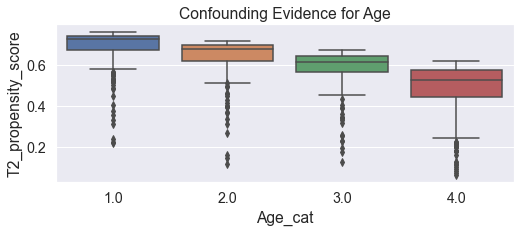

In [83]:
sns.boxplot(x="Age_cat", y="T2_propensity_score", data=merge2_0)
plt.title("Confounding Evidence for Age");

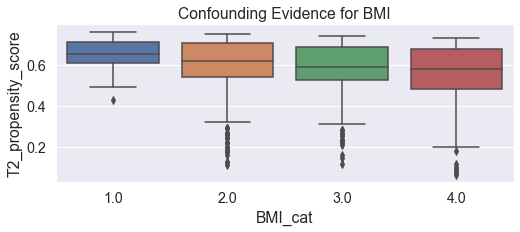

In [84]:
sns.boxplot(x="BMI_cat", y="T2_propensity_score", data=merge2_0)
plt.title("Confounding Evidence for BMI");

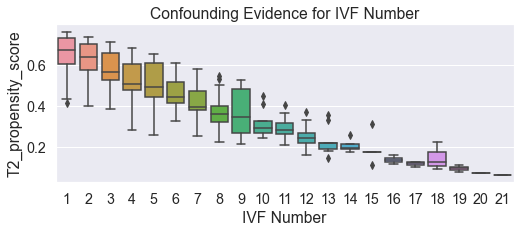

In [85]:
sns.boxplot(x="IVF Number", y="T2_propensity_score", data=merge2_0)
plt.title("Confounding Evidence for IVF Number");

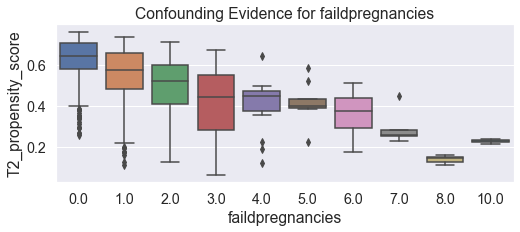

In [86]:
sns.boxplot(x="faildpregnancies", y="T2_propensity_score", data=merge2_0)
plt.title("Confounding Evidence for faildpregnancies");

# Matching Implementation

In [87]:
## calculate the logit of the propensity score for matching

In [88]:
 
def logit(p):
    logit_value = math.log(p / (1-p))
    return logit_value

merge2_0['T2_ps_logit'] = merge2_0['T2_propensity_score'].apply(lambda x: logit(x))

In [89]:
#Use Nearerst Neighbors to identify matching candidates. Then perform 1-to-1 matching by isolating/identifying groups of (T=1,T=0).

#Caliper: 25% of standart deviation of logit(propensity score)
caliper = np.std(merge2_0['T2_ps_logit']) * 0.25

print('\nCaliper (radius) is: {:.4f}\n'.format(caliper))


merge2_0=merge2_0.reset_index()

knn = NearestNeighbors(n_neighbors=merge2_0.shape[0]-1 , p = 2, radius=caliper)
knn.fit(merge2_0[['T2_ps_logit']].to_numpy())



Caliper (radius) is: 0.1489



NearestNeighbors(n_neighbors=1365, radius=0.14885158701983073)

In [90]:
#For each data point (based on the logit propensity score) obtain (at most) 10 nearest matches. This is regardless of their treatment status.
# Common support distances and indexes

distances , neighbor_indexes = knn.kneighbors(
    merge2_0[['T2_ps_logit']].to_numpy(), \
    n_neighbors=merge2_0.shape[0]-1)


In [91]:
valid_indexes = merge2_0.index.values  # get a list of valid index values
matched_control = []

for current_index in valid_indexes:
    row = merge2_0.loc[current_index]
    if row['T'] == 0:
        merge2_0.loc[current_index, 'matched'] = np.nan
    else:
        for idx in neighbor_indexes[current_index, :]:# מציאת שכן מקבוצת טיפול נגדית 
            if (current_index != idx) and (idx in valid_indexes) and (merge2_0.loc[idx]['T'] == 0):
                if idx not in matched_control:
                    merge2_0.loc[current_index, 'matched'] = idx
                    matched_control.append(idx)
                    break

In [92]:
# try to increase the number of neighbors and/or caliper to get more matches
print('total observations in treatment 2:', len(merge2_0[merge2_0['T']==2]))
print('total matched observations in control 0:', len(matched_control))

total observations in treatment 2: 803
total matched observations in control 0: 563


In [93]:
# control have no match
treatment_matched = merge2_0.dropna(subset=['matched'])  # drop not matched

# matched control observation indexes
control_matched_idx = treatment_matched.matched
control_matched_idx = control_matched_idx.astype(int)  # change to int
control_matched_2_0 = merge2_0.loc[control_matched_idx, :]  # select matched control observations

# combine the matched treatment and control
df_matched_2_0 = pd.concat([treatment_matched, control_matched_2_0])

df_matched_2_0['T'].value_counts()

0.0    563
2.0    563
Name: T, dtype: int64

In [94]:
#matched control and treatment
df_matched_control_2_0 = df_matched_2_0[df_matched_2_0['T']==0]
df_matched_treatment_2_0 = df_matched_2_0[df_matched_2_0['T']==2]
df_matched_control_2_0
df_matched_treatment_2_0

,index,BMI,IVF Number,Age,T,Pregnant,BMI_cat,Age_cat,faildpregnancies,T2_propensity_score,T2_ps_logit,matched
0,4,28.888889,7,28.777550,2.0,0,3.0,1.0,0.0,0.565423,0.263202,937.0
1,9,28.888889,15,30.702259,2.0,0,3.0,1.0,0.0,0.313333,-0.784585,1147.0
2,13,19.607157,1,38.266940,2.0,0,2.0,3.0,0.0,0.658108,0.654876,1151.0
3,22,17.630854,1,40.164271,2.0,1,1.0,4.0,1.0,0.588504,0.357783,843.0
4,26,25.390625,1,38.272416,2.0,1,3.0,3.0,2.0,0.584248,0.340239,1335.0
...,...,...,...,...,...,...,...,...,...,...,...,...
558,4564,23.233456,1,28.120465,2.0,0,2.0,1.0,0.0,0.751448,1.106350,1310.0
559,4574,23.372576,1,38.472279,2.0,0,2.0,3.0,0.0,0.658108,0.654876,1001.0
560,4583,28.719723,1,37.900068,2.0,0,3.0,4.0,0.0,0.591901,0.371830,1311.0
561,4585,28.719723,3,38.121834,2.0,0,3.0,3.0,0.0,0.583126,0.335621,1312.0


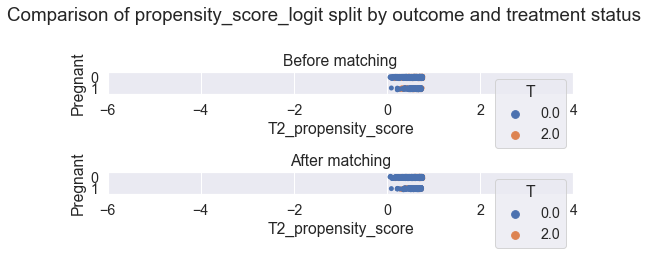

In [95]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(2,1)
fig.suptitle('Comparison of {} split by outcome and treatment status'.format('propensity_score_logit'))
sns.stripplot(data = merge2_0, y = 'Pregnant', x = 'T2_propensity_score', hue = 'T', orient = 'h', ax = ax[0]).set(title = 'Before matching', xlim=(-6, 4))
sns.stripplot(data = df_matched_2_0, y = 'Pregnant', x = 'T2_propensity_score', hue = 'T', ax = ax[1] , orient = 'h').set(title = 'After matching', xlim=(-6, 4))
plt.subplots_adjust(hspace = 0.3)
plt.show()
#plt.rcParams["figure.figsize"] = (40,6.5)
fig.savefig("jitter_plot.png")

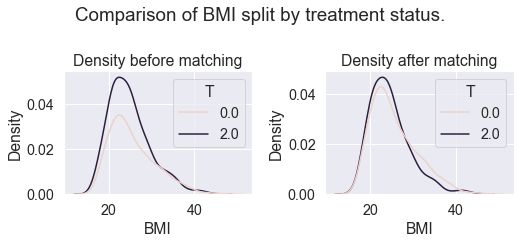

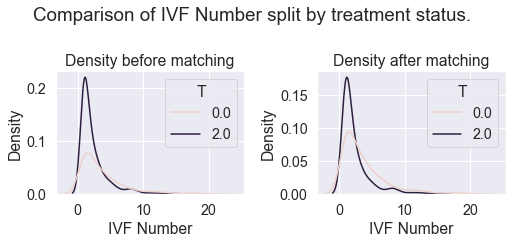

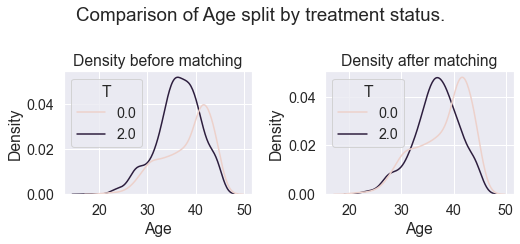

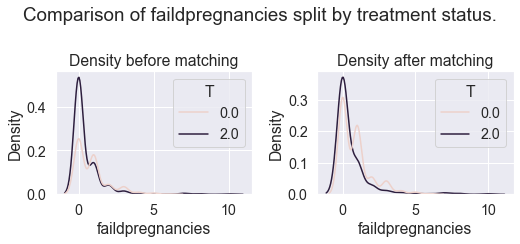

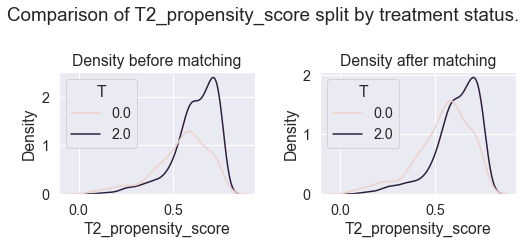

In [96]:
args = ['BMI','IVF Number','Age','faildpregnancies','T2_propensity_score']
#plt.rcParams["figure.figsize"] = (50,20)
def plot(arg):
    fig, ax = plt.subplots(1,2)
    fig.suptitle('Comparison of {} split by treatment status.'.format(arg))
    sns.kdeplot(data = merge2_0, x = arg, hue = 'T', ax = ax[0]).set(title='Density before matching')
    sns.kdeplot(data = df_matched_2_0, x = arg, hue = 'T',  ax = ax[1]).set(title='Density after matching')
    plt.show()
    fig.savefig("{}_comparison.png".format(arg))

for arg in args:
    plot(arg)

In [97]:
effect_sizes = []
cols = ['BMI','IVF Number','Age','faildpregnancies']

for cl in cols:
    _, p_before = ttest_ind(T2_control_0[cl], T2_treated[cl])
    _, p_after = ttest_ind(df_matched_control_2_0[cl], df_matched_treatment_2_0[cl])
    cohen_d_before = cohen_d(T2_treated[cl], T2_control_0[cl])
    cohen_d_after = cohen_d(df_matched_treatment_2_0[cl], df_matched_control_2_0[cl])
    effect_sizes.append([cl,'before', cohen_d_before, p_before])
    effect_sizes.append([cl,'after', cohen_d_after, p_after])
df_effect_sizes = pd.DataFrame(effect_sizes, columns=['feature', 'matching', 'effect_size', 'p-value'])
df_effect_sizes

,feature,matching,effect_size,p-value
0,BMI,before,-0.127735,2.028362e-02
1,BMI,after,-0.182750,2.219904e-03
2,IVF Number,before,-0.464407,7.454559e-17
3,IVF Number,after,-0.442132,2.336412e-13
4,Age,before,-0.337437,1.088554e-09
5,Age,after,-0.294472,8.967525e-07
6,faildpregnancies,before,-0.285237,2.432641e-07
7,faildpregnancies,after,-0.213456,3.564335e-04


<AxesSubplot:xlabel='effect_size', ylabel='feature'>

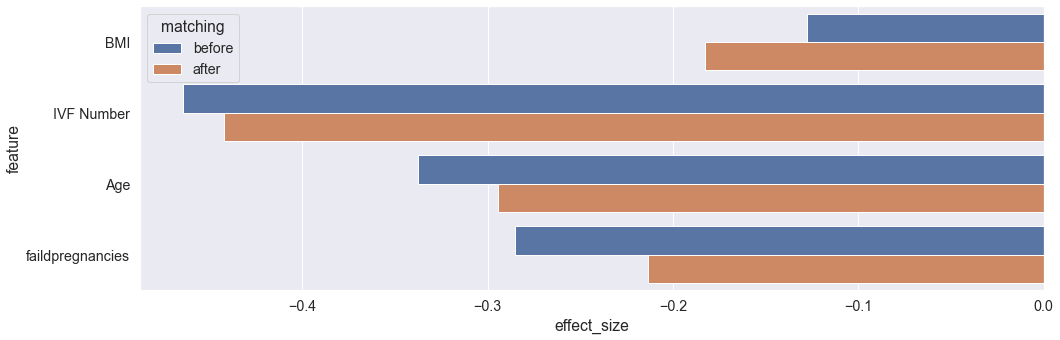

In [98]:
# discount_pct and featured are not significant, all other features are more balanced after matching
fig, ax = plt.subplots(figsize=(15, 5))
sns.barplot(data=df_effect_sizes, x='effect_size', y='feature', hue='matching', orient='h')

# Average Treatement effect

In [99]:
overview_2_0 = df_matched_2_0[['Pregnant','T']].groupby(by = ['T']).aggregate([np.mean, np.var, np.std, 'count'])
print(overview_2_0)

     Pregnant                          
         mean       var       std count
T                                      
0.0  0.174067  0.144024  0.379505   563
2.0  0.081705  0.075163  0.274159   563


In [100]:
treated_outcome_2_0 = overview_2_0['Pregnant']['mean'][2]
treated_counterfactual_outcome_2_0 = overview_2_0['Pregnant']['mean'][0]
att_2_0 = treated_outcome_2_0 - treated_counterfactual_outcome_2_0
print('The Average Treatment Effect (ATE): {:.4f}'.format(abs(att_2_0)))
Point_estimate_matching2 = att_2_0

The Average Treatment Effect (ATE): 0.0924


# ATE BY T -LEARNER

In [101]:
np.random.seed(123)
from sklearn.model_selection import train_test_split

m0 = ltb.LGBMRegressor(max_depth=2, min_child_samples=60)
m1 = ltb.LGBMRegressor(max_depth=2, min_child_samples=60)

m0.fit(merge2_0[merge2_0['T']==0][cols], merge2_0[merge2_0['T']==0]['Pregnant'])
m1.fit(merge2_0[merge2_0['T']==2][cols], merge2_0[merge2_0['T']==2]['Pregnant'])

# estimate the CATE
t_learner_cate_2_0 = m1.predict(merge2_0[cols]) - m0.predict(merge2_0[cols])

# print("The ATE by T learner :",t_learner_cate_1_0.mean())

Point_estimate_T2 = t_learner_cate_2_0.mean()

np.random.seed(123)
B = 500
ATE_ESTIMATOR2=[]
nrow = merge2_0.shape[0]

for i in range(B):
    # Take a bootstrap sample
    bootstrap_sample = merge2_0.sample(n=nrow, replace=True, random_state=i) #n = 200 #
    m0 = ltb.LGBMRegressor(max_depth=2, min_child_samples=60)
    m1 = ltb.LGBMRegressor(max_depth=2, min_child_samples=60)

    m0.fit(bootstrap_sample[bootstrap_sample['T']==0][cols], bootstrap_sample[bootstrap_sample['T']==0]['Pregnant'])
    m1.fit(bootstrap_sample[bootstrap_sample['T']==2][cols], bootstrap_sample[bootstrap_sample['T']==2]['Pregnant'])

    # estimate the CATE
    t_learner_cate_2_0 = m1.predict(merge2_0[cols]) - m0.predict(merge2_0[cols])

    ATE_ESTIMATOR2.append(t_learner_cate_2_0.mean())
    
ATE_ESTIMATOR2=list(np.array(ATE_ESTIMATOR2))    
beta_list = sorted(ATE_ESTIMATOR2, reverse = False)
CI_2_0_T_min = np.quantile(beta_list, 0.025)
CI_2_0_T_max = np.quantile(beta_list, 1-0.025)
# print("The credible interval:[", CI_1_min.round(3), CI_1_max.round(3) , "]")

print("Point estimate for ATE using  T-Learner:" , Point_estimate_T2.round(4)) 
print("95% CI for ATE using T-Learner: [", CI_2_0_T_min.round(4), CI_2_0_T_max.round(4) , "]")


Point estimate for ATE using  T-Learner: -0.031
95% CI for ATE using T-Learner: [ -0.0623 0.0053 ]


# s learner 

In [102]:
# S-Learner groups 2 and 0 #

np.random.seed(123)
s_learner = ltb.LGBMRegressor(max_depth=3, min_child_samples=30)
cols_t=['BMI_cat','IVF Number','Age_cat','faildpregnancies','T']
s_learner.fit( merge2_0[cols_t], merge2_0['Pregnant']);
predict_under_treatment=s_learner.predict(merge2_0[cols].assign(**{'T': 2}))
predict_under_control=s_learner.predict(merge2_0[cols].assign(**{'T': 0}))
sum_treatment=(predict_under_treatment-predict_under_control)
ATE_S_2_0=sum_treatment.mean()
Point_estimate_S2 = ATE_S_2_0

np.random.seed(123)
B = 500
S_ATE_ESTIMATOR2=[]
nrow = merge2_0.shape[0]

for i in range(B):
    # Take a bootstrap sample
    bootstrap_sample = merge2_0.sample(n=nrow, replace=True, random_state=i) #n = 200 #
    s_learner = ltb.LGBMRegressor(max_depth=3, min_child_samples=30)
    cols_t=['BMI_cat','IVF Number','Age_cat','faildpregnancies','T']
    s_learner.fit( bootstrap_sample[cols_t], bootstrap_sample['Pregnant']);
    predict_under_treatment=s_learner.predict(bootstrap_sample[cols].assign(**{'T': 2}))
    predict_under_control=s_learner.predict(bootstrap_sample[cols].assign(**{'T': 0}))
    sum_treatment=(predict_under_treatment-predict_under_control)
    ATE_S_2_0=sum_treatment.mean()

    S_ATE_ESTIMATOR2.append(ATE_S_2_0)
    
S_ATE_ESTIMATOR2=list(np.array(S_ATE_ESTIMATOR2))    
beta_list = sorted(S_ATE_ESTIMATOR2, reverse = False)
CI_2_0_S_min = np.quantile(beta_list, 0.025)
CI_2_0_S_max = np.quantile(beta_list, 1-0.025)


print("Point estimate for ATE using S-Learner:" , Point_estimate_S2.round(4)) 
print("95% CI for ATE using S-Learner: [", CI_2_0_S_min.round(4), CI_2_0_S_max.round(4) , "]")



Point estimate for ATE using S-Learner: -0.0078
95% CI for ATE using S-Learner: [ -0.0419 0.0343 ]


# ATE for treatment 2 control 0 by IPW

In [103]:
ATE_IPW_2_0=0
merge2_0_COPY=merge2_0.copy()
merge2_0_COPY['T'] = merge2_0_COPY['T'].replace([2], 1)
merge2_0_COPY

,index,BMI,IVF Number,Age,T,Pregnant,BMI_cat,Age_cat,faildpregnancies,T2_propensity_score,T2_ps_logit,matched
0,4,28.888889,7,28.777550,1.0,0,3.0,1.0,0.0,0.565423,0.263202,937.0
1,9,28.888889,15,30.702259,1.0,0,3.0,1.0,0.0,0.313333,-0.784585,1147.0
2,13,19.607157,1,38.266940,1.0,0,2.0,3.0,0.0,0.658108,0.654876,1151.0
3,22,17.630854,1,40.164271,1.0,1,1.0,4.0,1.0,0.588504,0.357783,843.0
4,26,25.390625,1,38.272416,1.0,1,3.0,3.0,2.0,0.584248,0.340239,1335.0
...,...,...,...,...,...,...,...,...,...,...,...,...
1361,6677,24.910767,1,40.892539,0.0,0,4.0,4.0,0.0,0.577989,0.314522,NaN
1362,6690,18.750000,1,26.157426,0.0,0,2.0,1.0,1.0,0.726649,0.977686,NaN
1363,6712,26.346494,1,33.133470,0.0,0,3.0,1.0,0.0,0.740591,1.049042,NaN
1364,6720,28.650138,2,39.121150,0.0,0,3.0,3.0,0.0,0.614577,0.466594,NaN


In [104]:
ATE_IPW_2_0=0
merge2_0_COPY=merge2_0.copy()

for idx, row in merge2_0_COPY.iterrows():
    sum_1=(row['T']*row['Pregnant'])/row['T2_propensity_score'] # in case T=1
    sum_0=(1-row['T'])*row['Pregnant']/(1-row['T2_propensity_score'])
    ATE_IPW_2_0+=sum_1 - sum_0
ATE_IPW_2_0=ATE_IPW_2_0/merge2_0.shape[0]



# Bootstrap 95% CI for IPW estimator # 

Point_estimate_IPW2 = ATE_IPW_2_0

np.random.seed(123)
B = 500
IPW_ESTIMATORS2=[]
nrow = merge2_0.shape[0]

for i in range(B):
    # Take a bootstrap sample
    sampledCases = np.int_(np.random.uniform(0,nrow,nrow))
    bootstrap_sample = merge2_0_COPY.iloc[sampledCases].copy()
    ATE_IPW_2_0=0

    for idx, row in bootstrap_sample.iterrows():
        sum_1=(row['T']*row['Pregnant'])/row['T2_propensity_score'] # in case T=1
        sum_0=(1-row['T'])*row['Pregnant']/(1-row['T2_propensity_score'])
        ATE_IPW_2_0+=sum_1 - sum_0
    ATE_IPW_2_0=ATE_IPW_2_0/bootstrap_sample.shape[0]

    IPW_ESTIMATORS2.append(ATE_IPW_2_0.mean())
    
    
IPW_ESTIMATORS2=list(np.array(IPW_ESTIMATORS2))    
beta_list = sorted(IPW_ESTIMATORS2, reverse = False)
CI_2_0_IPW_min = np.quantile(beta_list, 0.025)
CI_2_0_IPW_max = np.quantile(beta_list, 1-0.025)
print("Point estimate for ATE using IPW:" , Point_estimate_IPW2.round(3)) 
print("95% CI for ATE using IPW: [", CI_2_0_IPW_min.round(3) , CI_2_0_IPW_max.round(3) , "]")



Point estimate for ATE using IPW: 0.137
95% CI for ATE using IPW: [ 0.065 0.226 ]


# x learner 

In [105]:

# Keep only the treated units
df_treated = merge2_0[merge2_0['T'] == 2].copy()
# Features
features_treated = df_treated[['BMI_cat','IVF Number','Age_cat','faildpregnancies','T']]
# Dependent variable
y_treated = df_treated[['Pregnant']]
# Keep only the control units
df_control = merge2_0[merge2_0['T'] == 0].copy()
# Features
features_control = df_control[['BMI_cat','IVF Number','Age_cat','faildpregnancies','T']]
# Dependent variable
y_control = df_control[['Pregnant']]
# X-learner stage one model for the treated
s1_treated = LGBMRegressor().fit(features_treated, y_treated)
# X-learner stage one model for the control
s1_control = LGBMRegressor().fit(features_control, y_control)
    
# Predictions on the control group using the treated model
s1_treated_predict = s1_treated.predict(features_control)
# Predictions on the treated group using the control model
s1_control_predict = s1_control.predict(features_treated)
# Features for all the samples
features = merge2_0[['BMI_cat','IVF Number','Age_cat','faildpregnancies','T']].copy()
# Create a column for the predicted outcomes
df_treated['predicted_outcome'] = s1_control_predict
# Create a column for the imputed ite
df_treated['imputed_ite'] =  df_treated.apply(lambda row: row['Pregnant'] - row.predicted_outcome, axis = 1)
# Create a column for the predicted outcomes
df_control['predicted_outcome'] = s1_treated_predict
# Create a column for the imputed ite
df_control['imputed_ite'] =  df_control.apply(lambda row: row.predicted_outcome - row['Pregnant'], axis = 1)

# Light GBM model for the treated
s2_treated = LGBMRegressor().fit(features_treated, df_treated['imputed_ite'])
# Light GBM model for the control
s2_control = LGBMRegressor().fit(features_control, df_control['imputed_ite'])

    
   
# Predictions using the treated model
s2_treated_predict = s2_treated.predict(features)
# Save the prediction results as a colum in the dataframe
merge2_0['s2_treated_predict'] = s2_treated_predict
# Predictions using the control model
s2_control_predict = s2_control.predict(features)
# Save the prediction results as a colum in the dataframe
merge2_0['s2_control_predict'] = s2_control_predict
    
# Train the XGBoost model
xgb = XGBClassifier(seed=0).fit(features,bootstrap_sample[['T']])
# Make predictions
xgb_predict_prob = xgb.predict_proba(features)[:,1]
# Save the prediction results as a colum in the dataframe
merge2_0['treatment_propensity_score'] = xgb_predict_prob
# Calculate the weighted ITE
merge2_0['ITE'] = merge2_0.apply(lambda row: row.treatment_propensity_score*row.s2_control_predict + (1-row.treatment_propensity_score)*row.s2_treated_predict, axis=1)
    
# estimate the ATE
Point_estimate_X2 =merge2_0[['ITE']].mean()


[15:23:56] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [106]:
np.random.seed(123)
B = 500
ATE_ESTIMATOR_X=[]
nrow = merge2_0.shape[0]

for i in range(B):
    # Take a bootstrap sample
    bootstrap_sample = merge2_0.sample(n=nrow, replace=True, random_state=i) #n = 200 #
    # Keep only the treated units
    df_treated = bootstrap_sample[bootstrap_sample['T'] == 2].copy()
    # Features
    features_treated = df_treated[['BMI_cat','IVF Number','Age_cat','faildpregnancies','T']]
    # Dependent variable
    y_treated = df_treated[['Pregnant']]
    # Keep only the control units
    df_control = bootstrap_sample[bootstrap_sample['T'] == 0].copy()
    # Features
    features_control = df_control[['BMI_cat','IVF Number','Age_cat','faildpregnancies','T']]
    # Dependent variable
    y_control = df_control[['Pregnant']]
    # X-learner stage one model for the treated
    s1_treated = LGBMRegressor().fit(features_treated, y_treated)
    # X-learner stage one model for the control
    s1_control = LGBMRegressor().fit(features_control, y_control)
    
    # Predictions on the control group using the treated model
    s1_treated_predict = s1_treated.predict(features_control)
    # Predictions on the treated group using the control model
    s1_control_predict = s1_control.predict(features_treated)
    # Features for all the samples
    features = bootstrap_sample[['BMI_cat','IVF Number','Age_cat','faildpregnancies','T']].copy()
    # Create a column for the predicted outcomes
    df_treated['predicted_outcome'] = s1_control_predict
    # Create a column for the imputed ite
    df_treated['imputed_ite'] =  df_treated.apply(lambda row: row['Pregnant'] - row.predicted_outcome, axis = 1)
    # Create a column for the predicted outcomes
    df_control['predicted_outcome'] = s1_treated_predict
    # Create a column for the imputed ite
    df_control['imputed_ite'] =  df_control.apply(lambda row: row.predicted_outcome - row['Pregnant'], axis = 1)

    # Light GBM model for the treated
    s2_treated = LGBMRegressor().fit(features_treated, df_treated['imputed_ite'])
    # Light GBM model for the control
    s2_control = LGBMRegressor().fit(features_control, df_control['imputed_ite'])

    
   
    # Predictions using the treated model
    s2_treated_predict = s2_treated.predict(features)
    # Save the prediction results as a colum in the dataframe
    bootstrap_sample['s2_treated_predict'] = s2_treated_predict
    # Predictions using the control model
    s2_control_predict = s2_control.predict(features)
    # Save the prediction results as a colum in the dataframe
    bootstrap_sample['s2_control_predict'] = s2_control_predict
    
    # Train the XGBoost model
    xgb = XGBClassifier(seed=0,eval_metric='rmse').fit(features,bootstrap_sample[['T']])
    # Make predictions
    xgb_predict_prob = xgb.predict_proba(features)[:,1]
    # Save the prediction results as a colum in the dataframe
    bootstrap_sample['treatment_propensity_score'] = xgb_predict_prob
    # Calculate the weighted ITE
    bootstrap_sample['ITE'] = bootstrap_sample.apply(lambda row: row.treatment_propensity_score*row.s2_control_predict + (1-row.treatment_propensity_score)*row.s2_treated_predict, axis=1)
    
    # estimate the ATE
    ATE = bootstrap_sample[['ITE']].mean()
    ATE_ESTIMATOR_X.append(ATE[0])
    
    
    
   
    
ATE_ESTIMATOR_X=list(np.array(ATE_ESTIMATOR_X))    
beta_list = sorted(ATE_ESTIMATOR_X, reverse = False)
CI_2_0_X_min = np.quantile(beta_list, 0.025)
CI_2_0_X_max = np.quantile(beta_list, 1-0.025)
# print("The credible interval:[", CI_1_min.round(3), CI_1_max.round(3) , "]")

print("Point estimate for ATE using  T-Learner:" , ATE_X.round(4)) 
print("95% CI for ATE using T-Learner: [", CI_2_0_X_min.round(4), CI_2_0_X_max.round(4) , "]")



NameError: name 'ATE_X' is not defined

In [ ]:
print([CI_2_0_X_min,CI_2_0_X_max] )

# plot 

In [ ]:
ATE_no_covariants2_0=merge2_0[['Pregnant','T']].groupby(by = ['T']).aggregate([np.mean, np.var, np.std, 'count'])

ATE_no_covariants2_0=ATE_no_covariants2_0[("Pregnant","mean")][2] - ATE_no_covariants2_0[("Pregnant","mean")][0]
print("Naive ATE for treatment group T = 2 and control group T = 0:",ATE_no_covariants2_0 )
 

In [ ]:

from lightgbm.plotting import plot_importance
plot_importance(s_learner, color='r', title='t', xlabel='x', ylabel='y')

In [ ]:

data_dict = {}
data_dict['category'] = ['T LEARNER','S LEARNER','X LEARNER','IPW']
data_dict['lower'] = [CI_2_0_T_min,CI_2_0_S_min,CI_2_0_X_min,CI_2_0_IPW_min]
data_dict['upper'] = [CI_2_0_T_max,CI_2_0_S_max,CI_2_0_X_max,CI_2_0_IPW_max]
data_dict['Estimator'] = [Point_estimate_T2,Point_estimate_S2,Point_estimate_X2 ,Point_estimate_IPW2]
dataset = pd.DataFrame(data_dict)

for lower,upper,Estimator,y in zip(dataset['lower'],dataset['upper'],dataset['Estimator'],range(len(dataset))):
    #plt.plot((lower,mean,upper),(y,y,y),'ro-',color='orange')
    plt.plot((lower,upper),(y,y),'ro-',color='orange')
    plt.plot(Estimator,(y),'ro-',color='green',label='Estimator')
    plt.plot((ATE_no_covariants2_0),(y),'ro-',color='red',label='ATE NAIVE')
    

plt.yticks(range(len(dataset)),list(dataset['category']))
plt.title('Confidence Interval')

In [ ]:
B=[Point_estimate_T3,Point_estimate_S3,Point_estimate_X3 ,Point_estimate_IPW3]
print(B)

### Average ATE based on the average of our four estimates

In [ ]:
ATE_2_0= (Point_estimate_matching2 + Point_estimate_T2 + Point_estimate_S2 + Point_estimate_IPW2) / 4
ATE_2_0
#Again practically nothing#


In [ ]:
ATE_no_covariants2_0=merge2_0[['Pregnant','T']].groupby(by = ['T']).aggregate([np.mean, np.var, np.std, 'count'])

ATE_no_covariants2_0=ATE_no_covariants2_0[("Pregnant","mean")][1] - ATE_no_covariants2_0[("Pregnant","mean")][0]
print("Naive ATE for treatment group T = 2 and control group T = 0:",ATE_no_covariants2_0 )



import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

# Set the figure size
plt.rcParams["figure.figsize"] = [7.50, 3.50]
plt.rcParams["figure.autolayout"] = True

# Pandas dataframe
data = pd.DataFrame({"T LEARNER": ATE_ESTIMATOR2, "S LEARNER":S_ATE_ESTIMATOR2,"X LEARNER":ATE_ESTIMATOR_X_2,"IPW": IPW_ESTIMATORS2})

# Plot the dataframe
kx = data[['T LEARNER', 'S LEARNER',"X LEARNER","IPW"]].plot(kind='box', title='boxplot')


# Display the plot
plt.show()


# Treatment : T=2
# CONTROL:T=1

In [ ]:
# Split the data into treatment and control groups for each medication
T2_control_1 = new_data[new_data['T']  == 1].copy()


merge2_1=T2_treated.append(T2_control_1)
merge2_1=merge2_1.reset_index()

merge2_1.drop('index', inplace=True, axis=1)
merge2_1.drop('BMI', inplace=True, axis=1)#שימוש בקטגוריות
merge2_1.drop('Age', inplace=True, axis=1)

# Checking for differences in covariates

In [ ]:
merge2_1.groupby('T').mean()

# Comparing Age variable

In [ ]:
import matplotlib.pyplot as plt
 
# plotting  age histogram for treatment 1
plt.hist(T2_control_1['Age'], label='Age treatment 1', alpha=.7, color='red')

# plotting age histogram for treatment 2
plt.hist(T2_treated['Age'], label="Age treatment 2", alpha=.5,
         edgecolor='black', color='yellow')

plt.legend()
 
# Showing the plot using plt.show()
plt.show()

In [ ]:
# t-test for Age (dependent variable)
from scipy.stats import ttest_ind

print(T2_control_1['Age'].mean(), T2_treated['Age'].mean())

# compare samples
_, p = ttest_ind(T2_control_1['Age'], T2_treated['Age'])
print(f'p={p:.3f}')

# interpret
alpha = 0.05  # significance level
print("The age field of treatment 2 and 1 have:")
if p > alpha:
    print(' same distributions/same group mean (fail to reject H0 - we do not have enough evidence to reject H0)')
else:
    print('different distributions/different group mean (reject H0)')

# Comparing BMI variable

In [ ]:
import matplotlib.pyplot as plt
 
# plotting treatment 1 BMI histogram
plt.hist(T2_control_1['BMI'], label='BMI treatment 1', alpha=.7, color='red')


# plotting treatment 2 BMI histogram
plt.hist(T2_treated['BMI'], label="BMI treatment 2", alpha=.5,
         edgecolor='black', color='yellow')

plt.legend()
 
# Showing the plot using plt.show()
plt.show()

# Examining the distribution of Failed Pregnancies

In [ ]:
import matplotlib.pyplot as plt
 
# plotting treatment 1 faild Pregnancies histogram
plt.hist(T2_control_1['faildpregnancies'], label='faildpregnancies treatment 1', alpha=.7, color='red')

 
# plotting treatment 2 faild Pregnancies histogram
plt.hist(T2_treated['faildpregnancies'], label="faildpregnancies treatment 2", alpha=.5,
         edgecolor='black', color='yellow')

plt.legend()
 
# Showing the plot using plt.show()
plt.show()

In [ ]:
#  t-test for faild Pregnancies (dependent variable)
from scipy.stats import ttest_ind

print(T2_control_1['faildpregnancies'].mean(), T2_treated['faildpregnancies'].mean())

# compare samples
_, p = ttest_ind(T2_control_1['faildpregnancies'], T2_treated['faildpregnancies'])
print(f'p={p:.3f}')

# interpret
alpha = 0.05  # significance level
print("The faild pregnancies field of treatment 2 and 1 have:")
if p > alpha:
    print(' same distributions/same group mean (fail to reject H0 - we do not have enough evidence to reject H0)')
else:
    print('different distributions/different group mean (reject H0)')

#  Comparing IVF Number variable

In [ ]:
import matplotlib.pyplot as plt
 
# plotting treatment 1 IVF Number histogram
plt.hist(T2_control_1['IVF Number'], label='IVF Number treatment 1', alpha=.7, color='red')

# plotting treatment 2 IVF Number histogram
plt.hist(T2_treated['IVF Number'], label="IVF Number treatment 2", alpha=.5,
         edgecolor='black', color='yellow')

plt.legend()
 
# Showing the plot using plt.show()
plt.show()

# propensity scores

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression as lr

covariate_cols=['BMI_cat','IVF Number','Age_cat','faildpregnancies']
# Design pipeline to build the treatment estimator
pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('logistic_classifier', lr())# Train a logistic regression model to estimate propensity scores for each medication
])

pipe.fit(merge2_1[covariate_cols],merge2_1['T'])

# prediction

In [ ]:
T2_control_1['T2_propensity_score'] = pipe.predict_proba(T2_control_1[covariate_cols])[:, 1]
T2_treated['T2_propensity_score'] = pipe.predict_proba(T2_treated[covariate_cols])[:, 1]
merge2_1=T2_treated.append(T2_control_1)

In [ ]:
predictions_binary = pipe.predict(merge2_1[covariate_cols])

In [ ]:
from sklearn import metrics
T = merge2_1['T']
print('Accuracy of prediction: {:.4f}\n'.format(metrics.accuracy_score(T, predictions_binary)))

# overlap of ps for control 1 and treatment 2 using histogram

In [ ]:
# check the overlap of ps for control and treatment using histogram
# if not much overlap, the matching won't work
sns.histplot(data=merge2_1, x='T2_propensity_score', hue='T').set_title('Overlap for propensity scores \n Treatment groups T = 2 and T = 1') 


In [ ]:
sns.boxplot(x="Age_cat", y="T2_propensity_score", data=merge2_1)
plt.title("Confounding Evidence for Age");

In [ ]:
sns.boxplot(x="BMI_cat", y="T2_propensity_score", data=merge2_1)
plt.title("Confounding Evidence for BMI");

In [ ]:
sns.boxplot(x="IVF Number", y="T2_propensity_score", data=merge2_1)
plt.title("Confounding Evidence for IVF Number");

In [ ]:
sns.boxplot(x="faildpregnancies", y="T2_propensity_score", data=merge2_1)
plt.title("Confounding Evidence for faildpregnancies");

# Matching Implementation

In [ ]:
## calculate the logit of the propensity score for matching

In [ ]:
import math 
def logit(p):
    logit_value = math.log(p / (1-p))
    return logit_value

merge2_1['T2_ps_logit'] = merge2_1['T2_propensity_score'].apply(lambda x: logit(x))

In [ ]:
#Use Nearerst Neighbors to identify matching candidates. Then perform 1-to-1 matching by isolating/identifying groups of (T=1,T=0).

#Caliper: 25% of standart deviation of logit(propensity score)
caliper = np.std(merge2_1['T2_ps_logit']) * 0.25

print('\nCaliper (radius) is: {:.4f}\n'.format(caliper))


merge2_1=merge2_1.reset_index()

knn = NearestNeighbors(n_neighbors=merge2_1.shape[0]-1 , p = 2, radius=caliper)
knn.fit(merge2_1[['T2_ps_logit']].to_numpy())


In [ ]:
#For each data point (based on the logit propensity score) obtain (at most) 10 nearest matches. This is regardless of their treatment status.
# Common support distances and indexes

distances , neighbor_indexes = knn.kneighbors(
    merge2_1[['T2_ps_logit']].to_numpy(), \
    n_neighbors=merge2_1.shape[0]-1)


In [ ]:
valid_indexes = merge2_1.index.values  # get a list of valid index values
matched_control = []

for current_index in valid_indexes:
    row = merge2_1.loc[current_index]
    if row['T'] == 1:
        merge2_1.loc[current_index, 'matched'] = np.nan
    else:
        for idx in neighbor_indexes[current_index, :]:# מציאת שכן מקבוצת טיפול נגדית 
            if (current_index != idx) and (idx in valid_indexes) and (merge2_1.loc[idx]['T'] == 1):
                if idx not in matched_control:
                    merge2_1.loc[current_index, 'matched'] = idx
                    matched_control.append(idx)
                    break

In [ ]:
# try to increase the number of neighbors and/or caliper to get more matches
print('total observations in treatment 2:', len(merge2_1[merge2_1['T']==2]))
print('total matched observations in control 1:', len(matched_control))

In [ ]:
# control have no match
treatment_matched = merge2_1.dropna(subset=['matched'])  # drop not matched

# matched control observation indexes
control_matched_idx = treatment_matched.matched
control_matched_idx = control_matched_idx.astype(int)  # change to int
control_matched_2_1 = merge2_1.loc[control_matched_idx, :]  # select matched control observations

# combine the matched treatment and control
df_matched_2_1 = pd.concat([treatment_matched, control_matched_2_1])

df_matched_2_1['T'].value_counts()

In [ ]:
#matched control and treatment
df_matched_control_2_1 = df_matched_2_1[df_matched_2_1['T']==1]
df_matched_treatment_2_1 = df_matched_2_1[df_matched_2_1['T']==2]
df_matched_control_2_1
df_matched_treatment_2_1

In [ ]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(2,1)
fig.suptitle('Comparison of {} split by outcome and treatment status'.format('propensity_score_logit'))
sns.stripplot(data = merge2_1, y = 'Pregnant', x = 'T2_propensity_score', hue = 'T', orient = 'h', ax = ax[0]).set(title = 'Before matching', xlim=(-6, 4))
sns.stripplot(data = df_matched_2_1, y = 'Pregnant', x = 'T2_propensity_score', hue = 'T', ax = ax[1] , orient = 'h').set(title = 'After matching', xlim=(-6, 4))
plt.subplots_adjust(hspace = 0.3)
plt.show()
#plt.rcParams["figure.figsize"] = (40,6.5)
fig.savefig("jitter_plot.png")

In [ ]:
args = ['BMI','IVF Number','Age','faildpregnancies','T2_propensity_score']
#plt.rcParams["figure.figsize"] = (50,20)
def plot(arg):
    fig, ax = plt.subplots(1,2)
    fig.suptitle('Comparison of {} split by treatment status.'.format(arg))
    sns.kdeplot(data = merge2_1, x = arg, hue = 'T', ax = ax[0]).set(title='Density before matching')
    sns.kdeplot(data = df_matched_2_1, x = arg, hue = 'T',  ax = ax[1]).set(title='Density after matching')
    plt.show()
    fig.savefig("{}_comparison.png".format(arg))

for arg in args:
    plot(arg)

In [ ]:
effect_sizes = []
cols = ['BMI','IVF Number','Age','faildpregnancies']

for cl in cols:
    _, p_before = ttest_ind(T2_control_1[cl], T2_treated[cl])
    _, p_after = ttest_ind(df_matched_control_2_1[cl], df_matched_treatment_2_1[cl])
    cohen_d_before = cohen_d(T2_treated[cl], T2_control_1[cl])
    cohen_d_after = cohen_d(df_matched_treatment_2_1[cl], df_matched_control_2_1[cl])
    effect_sizes.append([cl,'before', cohen_d_before, p_before])
    effect_sizes.append([cl,'after', cohen_d_after, p_after])
df_effect_sizes = pd.DataFrame(effect_sizes, columns=['feature', 'matching', 'effect_size', 'p-value'])
df_effect_sizes

In [ ]:
# discount_pct and featured are not significant, all other features are more balanced after matching
fig, ax = plt.subplots(figsize=(15, 5))
sns.barplot(data=df_effect_sizes, x='effect_size', y='feature', hue='matching', orient='h')

# Average Treatement effect BY MATCHING

In [ ]:
overview_2_1 = df_matched_2_1[['Pregnant','T']].groupby(by = ['T']).aggregate([np.mean, np.var, np.std, 'count'])
print(overview_2_1)

In [ ]:
treated_outcome_2_1 = overview_2_1['Pregnant']['mean'][1]
treated_counterfactual_outcome_2_1 = overview_2_1['Pregnant']['mean'][2]
att_2_1 = treated_outcome_2_1 - treated_counterfactual_outcome_2_1
print('The Average Treatment Effect (ATE): {:.4f}'.format(abs(att_2_1)))
Point_estimate_matching3 = att_2_1

# ATE BY T -LEARNER

In [ ]:
np.random.seed(123)
from sklearn.model_selection import train_test_split

m0 = ltb.LGBMRegressor(max_depth=2, min_child_samples=60)
m1 = ltb.LGBMRegressor(max_depth=2, min_child_samples=60)

m0.fit(merge2_1[merge2_1['T']==1][cols], merge2_1[merge2_1['T']==1]['Pregnant'])
m1.fit(merge2_1[merge2_1['T']==2][cols], merge2_1[merge2_1['T']==2]['Pregnant'])

# estimate the CATE
t_learner_cate_3_0 = m1.predict(merge2_1[cols]) - m0.predict(merge2_1[cols])


Point_estimate_T3 = t_learner_cate_3_0.mean()

np.random.seed(123)
B = 500
ATE_ESTIMATOR3=[]
nrow = merge2_1.shape[0]

for i in range(B):
    # Take a bootstrap sample
    bootstrap_sample = merge2_1.sample(n=nrow, replace=True, random_state=i) #n = 200 #
    m0 = ltb.LGBMRegressor(max_depth=2, min_child_samples=60)
    m1 = ltb.LGBMRegressor(max_depth=2, min_child_samples=60)

    m0.fit(bootstrap_sample[bootstrap_sample['T']==1][cols], bootstrap_sample[bootstrap_sample['T']==1]['Pregnant'])
    m1.fit(bootstrap_sample[bootstrap_sample['T']==2][cols], bootstrap_sample[bootstrap_sample['T']==2]['Pregnant'])

    # estimate the CATE
    t_learner_cate_3_0 = m1.predict(merge2_1[cols]) - m0.predict(merge2_1[cols])

    ATE_ESTIMATOR3.append(t_learner_cate_3_0.mean())
    
ATE_ESTIMATOR3=list(np.array(ATE_ESTIMATOR3))    
beta_list = sorted(ATE_ESTIMATOR3, reverse = False)
CI_2_1_T_min = np.quantile(beta_list, 0.025)
CI_2_1_T_max = np.quantile(beta_list, 1-0.025)
# print("The credible interval:[", CI_1_min.round(3), CI_1_max.round(3) , "]")

print("Point estimate for ATE using  T-Learner:" , Point_estimate_T3.round(4)) 
print("95% CI for ATE using T-Learner: [", CI_2_1_T_min, CI_2_1_T_max , "]")


In [ ]:
Point_estimate_T3

In [ ]:
# S-Learner groups 2 and 1 #

np.random.seed(123)
s_learner = ltb.LGBMRegressor(max_depth=3, min_child_samples=30)
cols_t=['BMI_cat','IVF Number','Age_cat','faildpregnancies','T']
s_learner.fit( merge2_1[cols_t], merge2_1['Pregnant']);
predict_under_treatment=s_learner.predict(merge2_1[cols].assign(**{'T': 2}))
predict_under_control=s_learner.predict(merge2_1[cols].assign(**{'T': 1}))
sum_treatment=(predict_under_treatment-predict_under_control)
ATE_S_2_1=sum_treatment.mean()
Point_estimate_S3 = ATE_S_2_1

np.random.seed(123)
B = 500
S_ATE_ESTIMATOR3=[]
nrow = merge2_1.shape[0]

for i in range(B):
    # Take a bootstrap sample
    bootstrap_sample = merge2_1.sample(n=nrow, replace=True, random_state=i) #n = 200 #
    s_learner = ltb.LGBMRegressor(max_depth=3, min_child_samples=30)
    cols_t=['BMI_cat','IVF Number','Age_cat','faildpregnancies','T']
    s_learner.fit( bootstrap_sample[cols_t], bootstrap_sample['Pregnant']);
    predict_under_treatment=s_learner.predict(bootstrap_sample[cols].assign(**{'T': 2}))
    predict_under_control=s_learner.predict(bootstrap_sample[cols].assign(**{'T': 1}))
    sum_treatment=(predict_under_treatment-predict_under_control)
    ATE_S_2_1=sum_treatment.mean()

    S_ATE_ESTIMATOR3.append(ATE_S_2_1)
    
S_ATE_ESTIMATOR3=list(np.array(S_ATE_ESTIMATOR3))    
beta_list = sorted(S_ATE_ESTIMATOR3, reverse = False)
CI_2_1_S_min = np.quantile(beta_list, 0.025)
CI_2_1_S_max = np.quantile(beta_list, 1-0.025)
# print("The credible interval:[", CI_1_min.round(3), CI_1_max.round(3) , "]")

print("Point estimate for ATE using  S-Learner:" , Point_estimate_S3.round(4)) 
print("95% CI for ATE using S-Learner: [", CI_2_1_S_min.round(4), CI_2_1_S_max.round(4) , "]")



# ATE for treatment 2 control 1 by IPW

In [ ]:
ATE_IPW_2_1=0

merge2_1_new = merge2_1.copy()
merge2_1_new["T"] = merge2_1_new["T"] - 1

for idx, row in merge2_1_new.iterrows():
    sum_1=(row['T']*row['Pregnant'])/row['T2_propensity_score'] # in case T=1
    sum_0=(1-row['T'])*row['Pregnant']/(1-row['T2_propensity_score'])
    ATE_IPW_2_1+=sum_1 - sum_0
ATE_IPW_2_1=ATE_IPW_2_1/merge2_1_new.shape[0]

# Bootstrap 95% CI for IPW estimator # 

Point_estimate_IPW3 = ATE_IPW_2_1

np.random.seed(123)
B = 500
IPW_ESTIMATORS3=[]
nrow = merge2_1_new.shape[0]

for i in range(B):
    # Take a bootstrap sample
    sampledCases = np.int_(np.random.uniform(0,nrow,nrow))
    bootstrap_sample = merge2_1_new.iloc[sampledCases].copy()
    ATE_IPW_2_1=0

    for idx, row in bootstrap_sample.iterrows():
        sum_1=(row['T']*row['Pregnant'])/row['T2_propensity_score'] # in case T=1
        sum_0=(1-row['T'])*row['Pregnant']/(1-row['T2_propensity_score'])
        ATE_IPW_2_1+=sum_1 - sum_0
    ATE_IPW_2_1=ATE_IPW_2_1/bootstrap_sample.shape[0]

    IPW_ESTIMATORS3.append(ATE_IPW_2_1.mean())
    
    
IPW_ESTIMATORS3=list(np.array(IPW_ESTIMATORS3))    
beta_list = sorted(IPW_ESTIMATORS3, reverse = False)
CI_2_1_IPW_min = np.quantile(beta_list, 0.025)
CI_2_1_IPW_max = np.quantile(beta_list, 1-0.025)
print("Point estimate for ATE using IPW:" , Point_estimate_IPW3.round(3)) 
print("95% CI for ATE using IPW: [", CI_2_1_IPW_min.round(3) , CI_2_1_IPW_max.round(3) , "]")



### Average ATE based on the average of our four estimates

In [ ]:
ATE_2_1 = (Point_estimate_matching3 + Point_estimate_T3 + Point_estimate_S3 + Point_estimate_IPW3) / 4
ATE_2_1
# Again basically no effect #

# X LEARNER

In [ ]:

# Keep only the treated units
df_treated = merge2_1[merge2_1['T'] == 2].copy()
# Features
features_treated = df_treated[['BMI_cat','IVF Number','Age_cat','faildpregnancies','T']]
# Dependent variable
y_treated = df_treated[['Pregnant']]
# Keep only the control units
df_control = merge2_1[merge2_1['T'] == 1].copy()
# Features
features_control = df_control[['BMI_cat','IVF Number','Age_cat','faildpregnancies','T']]
# Dependent variable
y_control = df_control[['Pregnant']]
# X-learner stage one model for the treated
s1_treated = LGBMRegressor().fit(features_treated, y_treated)
# X-learner stage one model for the control
s1_control = LGBMRegressor().fit(features_control, y_control)
    
# Predictions on the control group using the treated model
s1_treated_predict = s1_treated.predict(features_control)
# Predictions on the treated group using the control model
s1_control_predict = s1_control.predict(features_treated)
# Features for all the samples
features = merge2_1[['BMI_cat','IVF Number','Age_cat','faildpregnancies','T']].copy()
# Create a column for the predicted outcomes
df_treated['predicted_outcome'] = s1_control_predict
# Create a column for the imputed ite
df_treated['imputed_ite'] =  df_treated.apply(lambda row: row['Pregnant'] - row.predicted_outcome, axis = 1)
# Create a column for the predicted outcomes
df_control['predicted_outcome'] = s1_treated_predict
# Create a column for the imputed ite
df_control['imputed_ite'] =  df_control.apply(lambda row: row.predicted_outcome - row['Pregnant'], axis = 1)

# Light GBM model for the treated
s2_treated = LGBMRegressor().fit(features_treated, df_treated['imputed_ite'])
# Light GBM model for the control
s2_control = LGBMRegressor().fit(features_control, df_control['imputed_ite'])

    
   
# Predictions using the treated model
s2_treated_predict = s2_treated.predict(features)
# Save the prediction results as a colum in the dataframe
merge2_1['s2_treated_predict'] = s2_treated_predict
# Predictions using the control model
s2_control_predict = s2_control.predict(features)
# Save the prediction results as a colum in the dataframe
merge2_1['s2_control_predict'] = s2_control_predict
    
# Train the XGBoost model
xgb = XGBClassifier(seed=0, eval_metric='rmse').fit(features,bootstrap_sample[['T']])
# Make predictions
xgb_predict_prob = xgb.predict_proba(features)[:,1]
# Save the prediction results as a colum in the dataframe
merge2_1['treatment_propensity_score'] = xgb_predict_prob
# Calculate the weighted ITE
merge2_1['ITE'] = merge2_1.apply(lambda row: row.treatment_propensity_score*row.s2_control_predict + (1-row.treatment_propensity_score)*row.s2_treated_predict, axis=1)
    
# estimate the ATE
Point_estimate_X3 =merge2_1[['ITE']].mean()


# BOOST X 

In [ ]:
np.random.seed(123)
B = 500
ATE_ESTIMATOR_X=[]
nrow = merge2_1.shape[0]

for i in range(B):
    # Take a bootstrap sample
    bootstrap_sample = merge2_1.sample(n=nrow, replace=True, random_state=i) #n = 200 #
    # Keep only the treated units
    df_treated = bootstrap_sample[bootstrap_sample['T'] == 2].copy()
    # Features
    features_treated = df_treated[['BMI_cat','IVF Number','Age_cat','faildpregnancies','T']]
    # Dependent variable
    y_treated = df_treated[['Pregnant']]
    # Keep only the control units
    df_control = bootstrap_sample[bootstrap_sample['T'] == 1].copy()
    # Features
    features_control = df_control[['BMI_cat','IVF Number','Age_cat','faildpregnancies','T']]
    # Dependent variable
    y_control = df_control[['Pregnant']]
    # X-learner stage one model for the treated
    s1_treated = LGBMRegressor().fit(features_treated, y_treated)
    # X-learner stage one model for the control
    s1_control = LGBMRegressor().fit(features_control, y_control)
    
    # Predictions on the control group using the treated model
    s1_treated_predict = s1_treated.predict(features_control)
    # Predictions on the treated group using the control model
    s1_control_predict = s1_control.predict(features_treated)
    # Features for all the samples
    features = bootstrap_sample[['BMI_cat','IVF Number','Age_cat','faildpregnancies','T']].copy()
    # Create a column for the predicted outcomes
    df_treated['predicted_outcome'] = s1_control_predict
    # Create a column for the imputed ite
    df_treated['imputed_ite'] =  df_treated.apply(lambda row: row['Pregnant'] - row.predicted_outcome, axis = 1)
    # Create a column for the predicted outcomes
    df_control['predicted_outcome'] = s1_treated_predict
    # Create a column for the imputed ite
    df_control['imputed_ite'] =  df_control.apply(lambda row: row.predicted_outcome - row['Pregnant'], axis = 1)

    # Light GBM model for the treated
    s2_treated = LGBMRegressor().fit(features_treated, df_treated['imputed_ite'])
    # Light GBM model for the control
    s2_control = LGBMRegressor().fit(features_control, df_control['imputed_ite'])

    
   
    # Predictions using the treated model
    s2_treated_predict = s2_treated.predict(features)
    # Save the prediction results as a colum in the dataframe
    bootstrap_sample['s2_treated_predict'] = s2_treated_predict
    # Predictions using the control model
    s2_control_predict = s2_control.predict(features)
    # Save the prediction results as a colum in the dataframe
    bootstrap_sample['s2_control_predict'] = s2_control_predict
    
    # Train the XGBoost model
    xgb = XGBClassifier(seed=0, eval_metric='rmse').fit(features,bootstrap_sample[['T']])
    # Make predictions
    xgb_predict_prob = xgb.predict_proba(features)[:,1]
    # Save the prediction results as a colum in the dataframe
    bootstrap_sample['treatment_propensity_score'] = xgb_predict_prob
    # Calculate the weighted ITE
    bootstrap_sample['ITE'] = bootstrap_sample.apply(lambda row: row.treatment_propensity_score*row.s2_control_predict + (1-row.treatment_propensity_score)*row.s2_treated_predict, axis=1)
    
    # estimate the ATE
    ATE = bootstrap_sample[['ITE']].mean()
    ATE_ESTIMATOR_X.append(ATE[0])
    
    
    
   
    
ATE_ESTIMATOR_X=list(np.array(ATE_ESTIMATOR_X))    
beta_list = sorted(ATE_ESTIMATOR_X, reverse = False)
CI_2_1_X_min = np.quantile(beta_list, 0.025)
CI_2_1_X_max = np.quantile(beta_list, 1-0.025)
# print("The credible interval:[", CI_1_min.round(3), CI_1_max.round(3) , "]")

print("Point estimate for ATE using  X-Learner:" , ATE_X.round(4)) 
print("95% CI for ATE using X-Learner: [", CI_2_1_X_min.round(4), CI_2_1_X_max.round(4) , "]")

In [ ]:
CI_2_1_X_min = np.quantile(beta_list, 0.025)
print([CI_2_1_X_max,CI_2_1_X_min])

In [ ]:
ATE_no_covariants2_1=merge2_1[['Pregnant','T']].groupby(by = ['T']).aggregate([np.mean, np.var, np.std, 'count'])

ATE_no_covariants2_1=ATE_no_covariants2_1[("Pregnant","mean")][2] - ATE_no_covariants2_1[("Pregnant","mean")][1]
print("Naive ATE for treatment group T = 2 and control group T = 1:",ATE_no_covariants2_1 )

In [ ]:

data_dict = {}
data_dict['category'] = ['T LEARNER','S LEARNER','X LEARNER','IPW']
data_dict['lower'] = [CI_2_1_T_min,CI_2_1_S_min,CI_2_1_X_min,CI_2_1_IPW_min]
data_dict['upper'] = [CI_2_1_T_max,CI_2_1_S_max,CI_2_1_X_max,CI_2_1_IPW_max]
data_dict['Estimator'] = [Point_estimate_T3,Point_estimate_S3,Point_estimate_X3 ,Point_estimate_IPW3]
dataset = pd.DataFrame(data_dict)

for lower,upper,Estimator,y in zip(dataset['lower'],dataset['upper'],dataset['Estimator'],range(len(dataset))):
    #plt.plot((lower,mean,upper),(y,y,y),'ro-',color='orange')
    plt.plot((lower,upper),(y,y),'ro-',color='orange')
    plt.plot(Estimator,(y),'ro-',color='green',label='Estimator')
    plt.plot((ATE_no_covariants2_1),(y),'ro-',color='red',label='ATE NAIVE')
    

plt.yticks(range(len(dataset)),list(dataset['category']))
plt.title('Confidence Interval')


# Naive ATE

In [ ]:
ATE_no_covariants1_0=merge1_0[['Pregnant','T']].groupby(by = ['T']).aggregate([np.mean, np.var, np.std, 'count'])

ATE_no_covariants1_0=ATE_no_covariants1_0[("Pregnant","mean")][1] - ATE_no_covariants1_0[("Pregnant","mean")][0]
print("Naive ATE for treatment group T = 1 and control group T = 0:",ATE_no_covariants1_0 )





In [ ]:
plt.title('CI - Females')
plt.yticks([])

#CI_Female: (4.009140460544884, 12.324192872788448)
plt.hlines(y = 4, xmin =4.009, xmax = 12.324, color ='g', label='Sample size: 30')
plt.text(8,3.80, 'CI length=' + str(round(12.324-4.009, 2)))

#CI_Female: (5.043459961436776, 11.922057279942534)
plt.hlines(y = 3, xmin = 5.043, xmax = 11.922, color ='b', label='Sample size: 50') 
plt.text(8 ,2.77, 'CI length=' + str(round(11.922-5.043, 2)))

#CI_Female: (3.2137348736487903, 7.340111280197363)
plt.hlines(y = 2, xmin =3.213, xmax = 7.340, color ='r', label='Sample size: 100') 
plt.text(4.2, 1.8, 'CI length=' + str(round(7.340-3.213, 2)))

#CI_Female: (4.207309131319671, 6.00741309090255)
plt.hlines(y = 1, xmin =4.207, xmax = 6.007, color ='y', label='Sample size: 500') 
plt.text(4.2 ,0.8, 'CI length=' + str(round(6.007-4.207, 2)))

#original CI_Female (5.3196078357283305, 6.048726186594944)
plt.hlines(y = 0, xmin =5.319, xmax = 6.048, color ='orange', label='Sample size: 48842 (full data)') 
plt.text(5.5 ,0.05, 'CI length=' + str(round(6.048-5.319, 2)))

plt.legend(loc='best', fontsize=11, framealpha=1, frameon=True)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5),  prop={'size': 13})

plt.show()